# PURPOSE

The competition is designed to forecast the sales of thousands of items available at popular stores situated along the west coast of Ecuador in South America. The dataset originates from Corporación Favorita, a prominent grocery retailer in Ecuador. This company also has operations across various countries in South America.

# Description

The dataset encompasses **54 stores** and **33 product families** from Ecuador, with the time series spanning from **January 1, 2013, to August 31, 2017**. Kaggle has divided the data into 'train' and 'test' sets, with the test set covering the **15 days** following the train set's final date. This division is crucial for devising a cross-validation strategy and generating new features.

**The primary goal of this competition is to predict sales for each combination of product family and store.

Participants will engage with six distinct datasets:

1. **Train**: This includes time series data of sales for combinations of stores and product families. The 'sales' column indicates total sales for a product family in a store on a specific date, including fractional sales (e.g., 1.5 kg of cheese). The 'onpromotion' column shows the number of items on promotion in a product family at a store on a given date.

2. **Test**: This set contains the data for the subsequent 15 days after the train set, which is vital for testing the sales predictions.

3. **Stores**: Provides details about the stores, including city, state, store type, and cluster information.

4. **Transactions**: Closely linked with the 'sales' column in the train data, it reveals sales patterns.

5. **Holidays and Events**: Metadata that is crucial for understanding past sales, trends, and seasonality, although it requires careful manipulation.

6. **Daily Oil Price**: Since Ecuador's economy is sensitive to oil price fluctuations, this data can indicate how oil prices impact product family sales.

**The data description section also contains "Additional Notes" which are significant for identifying patterns or anomalies:**
- Public sector wages in Ecuador are paid biweekly on the **15th and the last day** of the month, which might influence supermarket sales.
  
- The aftermath of the 7.8 magnitude earthquake on April 16, 2016, in Ecuador saw a surge in relief efforts and donations, affecting supermarket sales for several weeks.

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression


comp_dir = Path('../input/store-sales-time-series-forecasting')

holidays_events = pd.read_csv(
    comp_dir / 'holidays_events.csv'
)

oil = pd.read_csv(
    comp_dir / 'oil.csv'
)

stores = pd.read_csv(
    comp_dir / 'stores.csv'
)

transactions = pd.read_csv(
    comp_dir / 'transactions.csv'
)

train = pd.read_csv(
    comp_dir / 'train.csv',
    parse_dates=['date']
)


test = pd.read_csv(
    comp_dir / 'test.csv'
)



In [2]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

First of all, we need to get the basic idea of what the train data is like:

In [3]:
display(train.head())
display(train.info())

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


None

In [4]:
min_values = train.drop(columns='family').min()
max_values = train.drop(columns='family').max()
unique_values_count = train.nunique()
unique_families = train['family'].unique()

print("Minimum Values:\n", min_values)
print("\nMaximum Values:\n", max_values)
print("\nNumber of Unique Values per Column:\n", unique_values_count)
print("\nUnique Values in 'family' Column:\n", unique_families)


Minimum Values:
 id                               0
date           2013-01-01 00:00:00
store_nbr                        1
sales                          0.0
onpromotion                      0
dtype: object

Maximum Values:
 id                         3000887
date           2017-08-15 00:00:00
store_nbr                       54
sales                     124717.0
onpromotion                    741
dtype: object

Number of Unique Values per Column:
 id             3000888
date              1684
store_nbr           54
family              33
sales           379610
onpromotion        362
dtype: int64

Unique Values in 'family' Column:
 ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLA

Based on the information we gathered so far, and the max value of each columns, we can comfortable do the following:

* Convert dtype for [id] from "int64" to "int32"
* Convert dtype for [store_nbr] from "int64" to "int8"
* Convert dtype for [family] from "object" to "category"
* Convert dtype for [sales] from "float64" to "float32"
* Convert dtype for [onpromotion] from "int64" to "int16"

The memory usage of the train dataset is pretty large, these conversions should reduce it.

In [5]:
print("Data types before conversion:")
print(train.dtypes)
print(f"Memory usage of the dataframe before conversions: {train.memory_usage(deep=True).sum() / 1024**2} MB\n")

train['id'] = train['id'].astype('int32')
train['store_nbr'] = train['store_nbr'].astype('int8')
train['family'] = train['family'].astype('category')
train['sales'] = train['sales'].astype('float32')
train['onpromotion'] = train['onpromotion'].astype('int16')

print("Data types after conversion:")
print(train.dtypes)
print(f"Memory usage of the dataframe after conversions: {train.memory_usage(deep=True).sum() / 1024**2} MB")


Data types before conversion:
id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object
Memory usage of the dataframe before conversions: 308.3882751464844 MB

Data types after conversion:
id                      int32
date           datetime64[ns]
store_nbr                int8
family               category
sales                 float32
onpromotion             int16
dtype: object
Memory usage of the dataframe after conversions: 57.24067306518555 MB


Indeed, the memory usage got reduced by more than half! This will be reflected throughout the analysis and model development.

# Average Sales By Day of week, Day, Week, and Month
# 



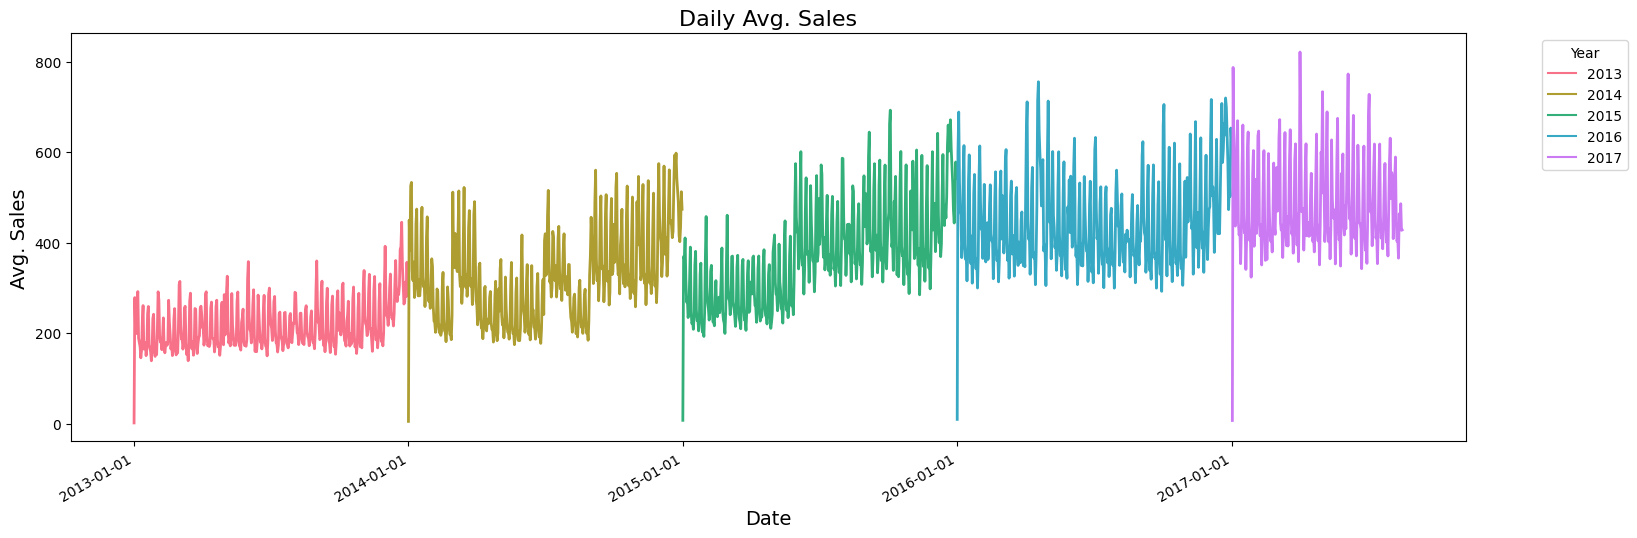

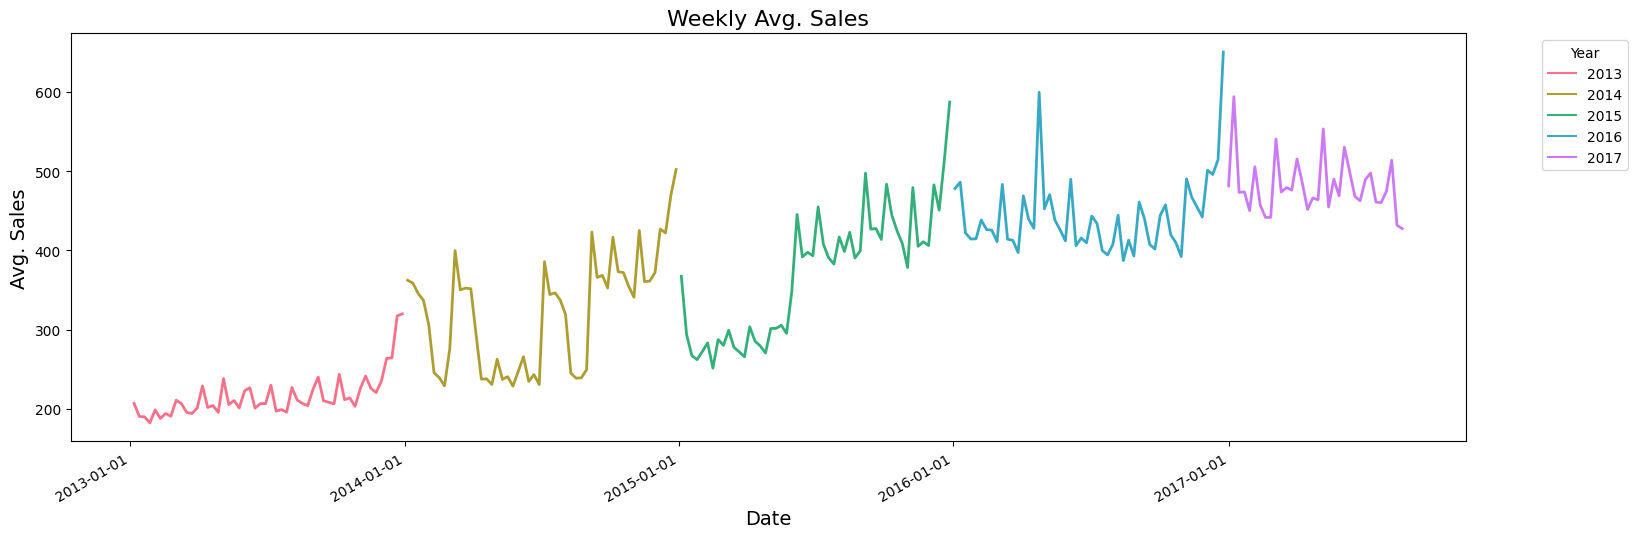

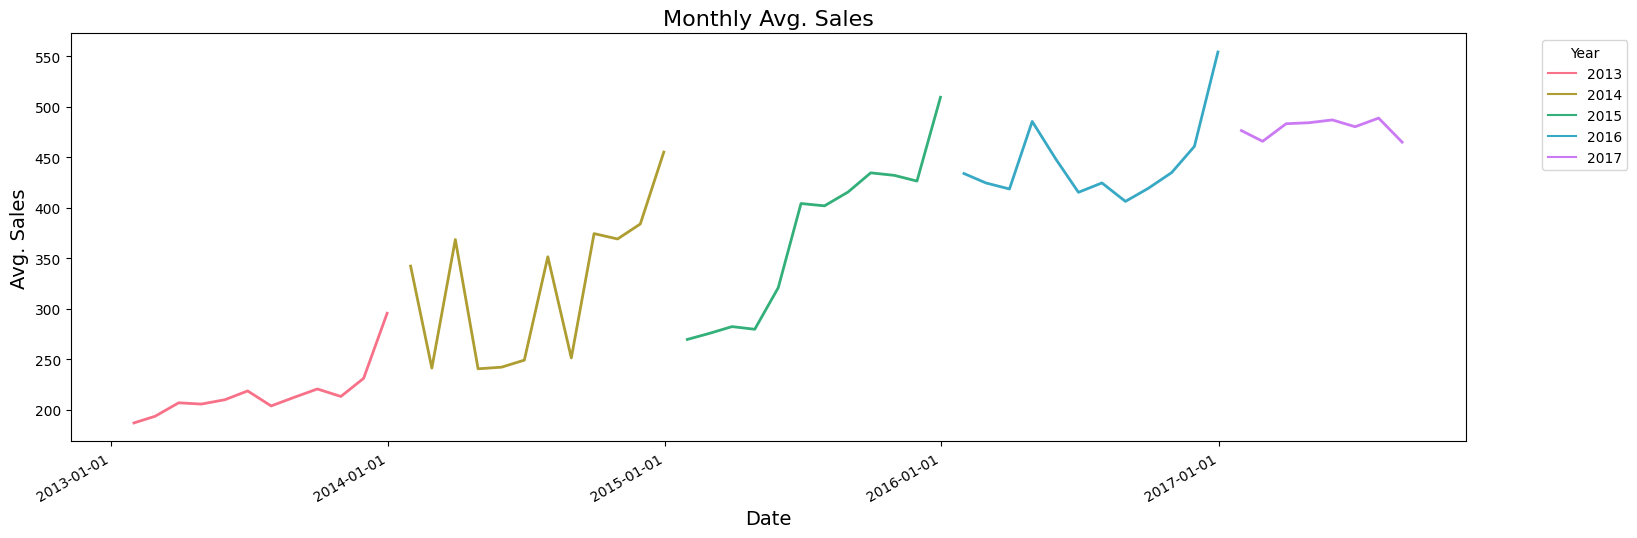

In [6]:
import matplotlib.dates as mdates

train_eda = train.copy()
train_eda['date'] = pd.to_datetime(train_eda['date'])  # Ensure that 'date' is datetime type
train_eda = train_eda.set_index('date')  # Setting date to index for simple handling

# Resampling data
daily_sales = train_eda.resample('D').sales.mean().to_frame()
weekly_sales = train_eda.resample('W').sales.mean().to_frame()
monthly_sales = train_eda.resample('M').sales.mean().to_frame()

dfs = [daily_sales, weekly_sales, monthly_sales]
titles = ['Daily Avg. Sales', 'Weekly Avg. Sales', 'Monthly Avg. Sales']

for df, title in zip(dfs, titles):
    
    # Creating a colorful line plot
    plt.figure(figsize=(18, 6))  # Set the size of the figure
    palette = sns.color_palette("husl", len(df.index.year.unique()))  # A vibrant color palette
    sns.lineplot(x=df.index, y=df.sales, hue=df.index.year, palette=palette, lw=2)
    
    # Improving the readability of the x-axis dates
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()  # Rotation

    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Avg. Sales', fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend out of the plot

    plt.show()  # Show plot



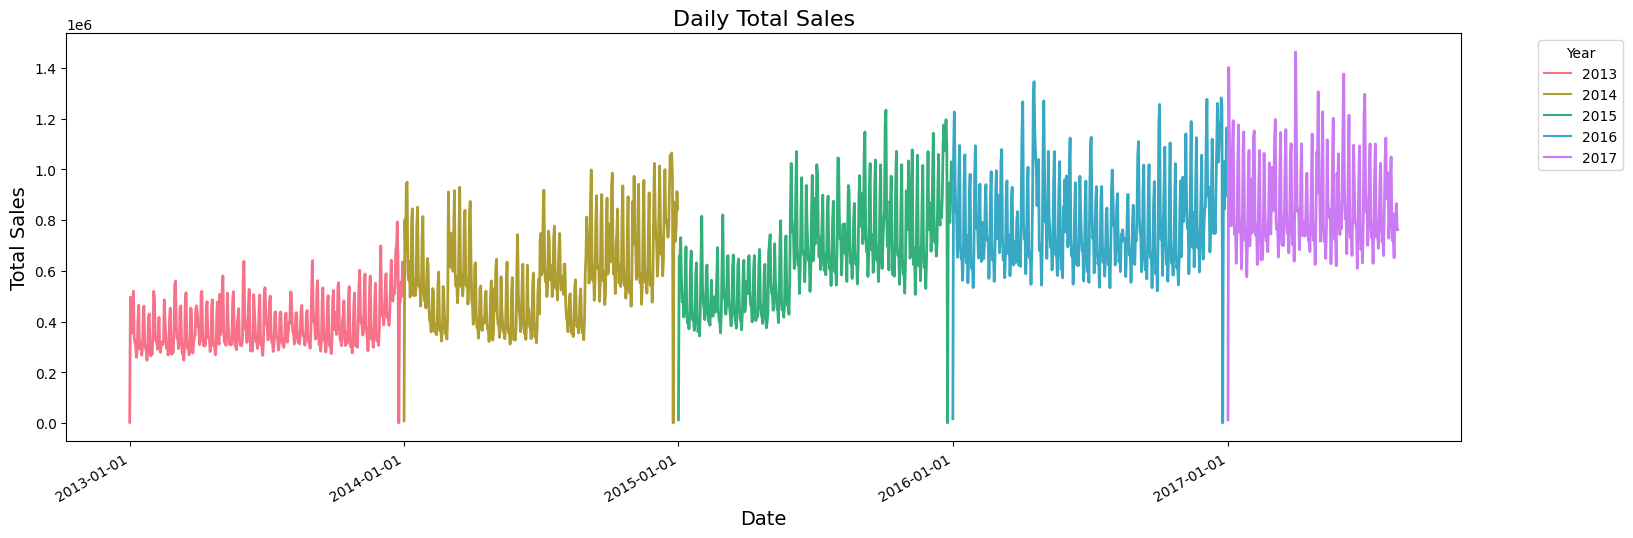

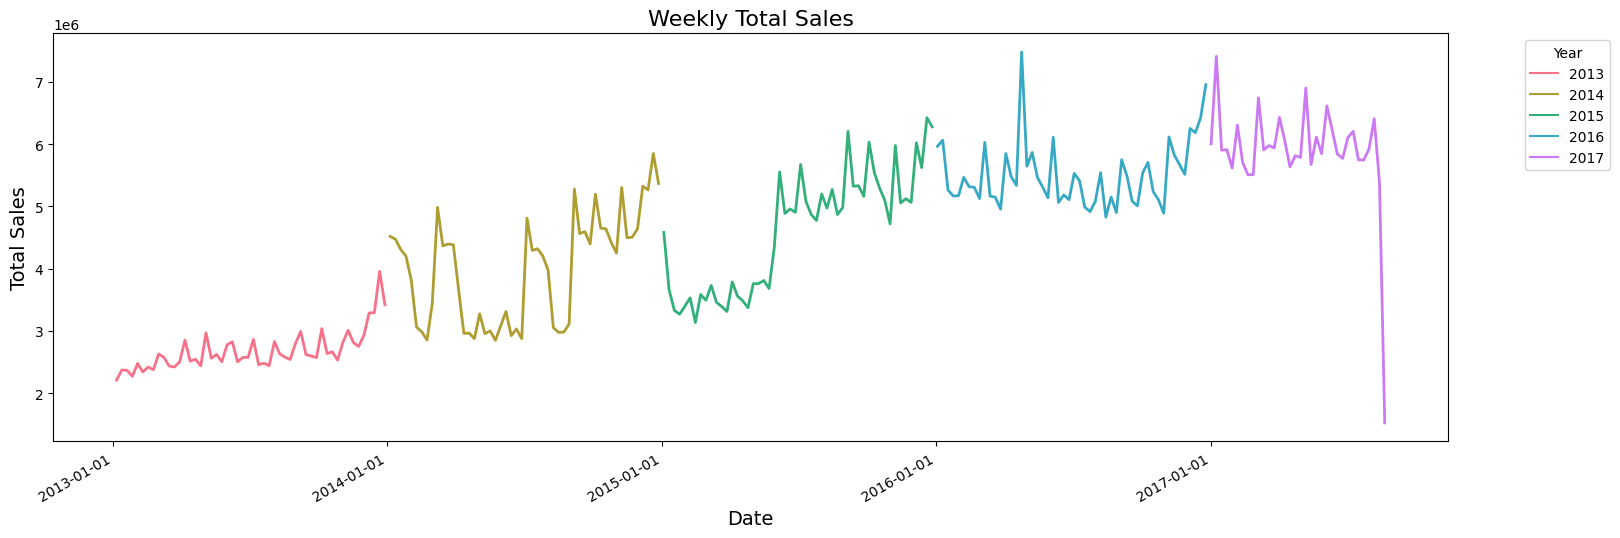

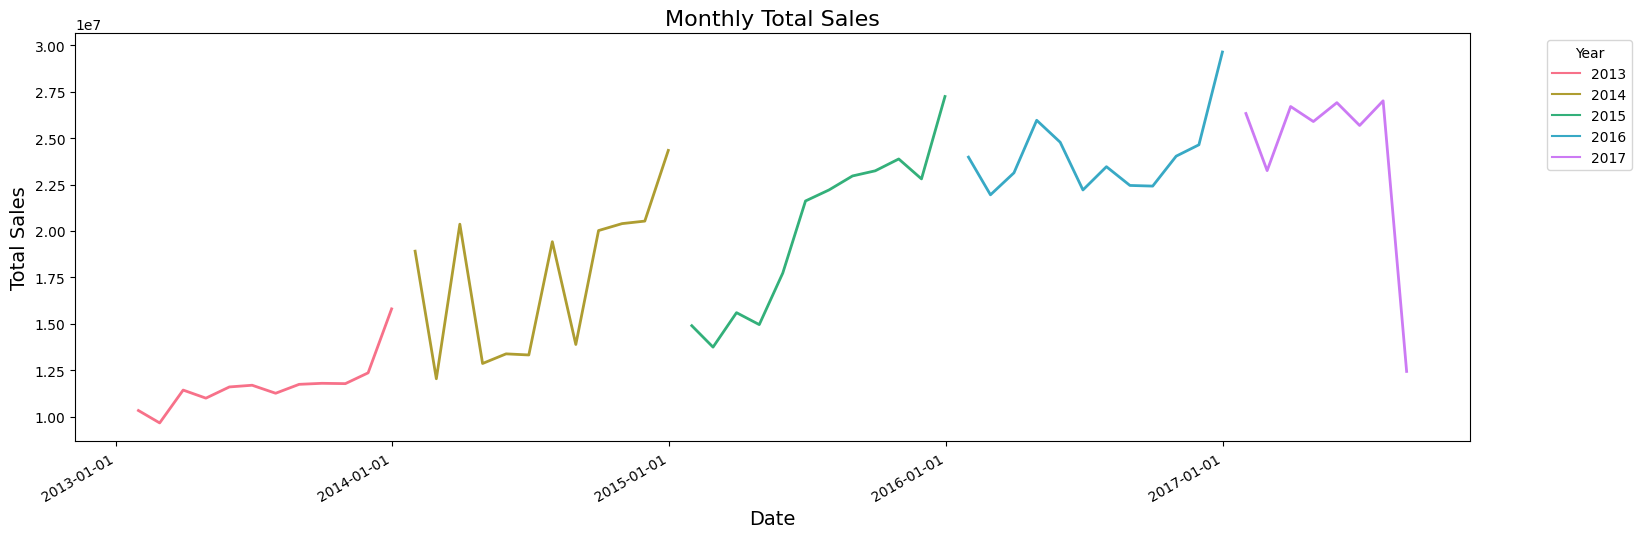

In [7]:
import matplotlib.dates as mdates

train_eda = train.copy()
train_eda['date'] = pd.to_datetime(train_eda['date'])  # Ensure that 'date' is datetime type
train_eda = train_eda.set_index('date')  # Setting date to index for simple handling

# Resampling data
daily_sales = train_eda.resample('D').sales.sum().to_frame()
weekly_sales = train_eda.resample('W').sales.sum().to_frame()
monthly_sales = train_eda.resample('M').sales.sum().to_frame()

dfs = [daily_sales, weekly_sales, monthly_sales]
titles = ['Daily Total Sales', 'Weekly Total Sales', 'Monthly Total Sales']

for df, title in zip(dfs, titles):
    
    # Creating a colorful line plot
    plt.figure(figsize=(18, 6))  # Set the size of the figure
    palette = sns.color_palette("husl", len(df.index.year.unique()))  # A vibrant color palette
    sns.lineplot(x=df.index, y=df.sales, hue=df.index.year, palette=palette, lw=2)
    
    # Improving the readability of the x-axis dates
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()  # Rotation

    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Total Sales', fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend out of the plot

    plt.show()  # Show plot



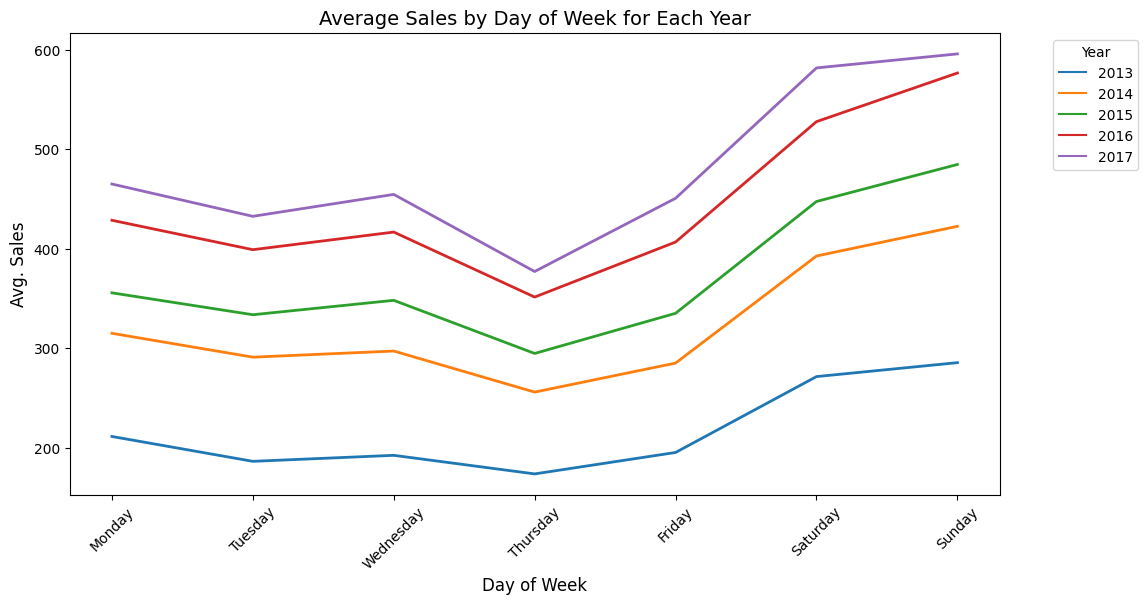

In [8]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt


# Grouping by year and then by day of the week
# Calculating mean sales for each combination
grouped_sales = train_eda.groupby([train_eda.index.year, train_eda.index.day_of_week])['sales'].mean()

# Before resetting the index, rename it to avoid conflict
grouped_sales.index.rename(['year', 'day_of_week'], inplace=True)

# Now reset the index. This will add 'year' and 'day_of_week' as columns without conflict.
grouped_sales_df = grouped_sales.to_frame('sales').reset_index()

# # Converting the grouped data to a DataFrame and resetting index for ease of plotting
# grouped_sales_df.rename(columns={'level_0': 'year', 'level_1':'day_of"week'}, inplace=True)

# Plotting
plt.figure(figsize=(12, 6))

palette = sns.color_palette("tab10", len(grouped_sales_df['year'].unique()))
sns.lineplot(data=grouped_sales_df, x='day_of_week', y='sales', hue='year', palette=palette, lw=2)

# Setting plot details
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Avg. Sales', fontsize=12)
plt.title('Average Sales by Day of Week for Each Year', fontsize=14)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')  # 


**Identifying the Trend:
**

We can visualize the long-term progression of the series by plotting a moving average. For a series with daily data points, a 365-day window is appropriate to level out the short-term variations and bring forth the underlying trend within an annual cycle.

To discern the overarching direction in which a time series is heading, a moving average graph can be quite telling. By averaging the data points within a specified sliding timeframe, each point on the moving average plot reflects the mean of the observations within that period. This method is effective for mitigating the noise from short-lived fluctuations, highlighting the sustained movements over time.

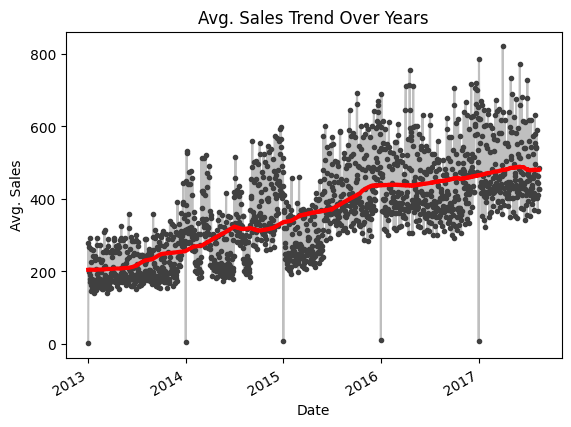

In [9]:
avg_sales=train_eda.groupby('date').sales.mean()
moving_avg=avg_sales.rolling(window=365,min_periods=183,center=True).mean()

ax=avg_sales.plot(**plot_params)
ax=moving_avg.plot(color='red',linewidth=3)
plt.xlabel('Date')
plt.ylabel('Avg. Sales')
plt.title('Avg. Sales Trend Over Years')
plt.show()

The upward trend and the bend at the end suggests that an order 2 polynomial might be appropriate in modeling this time series.

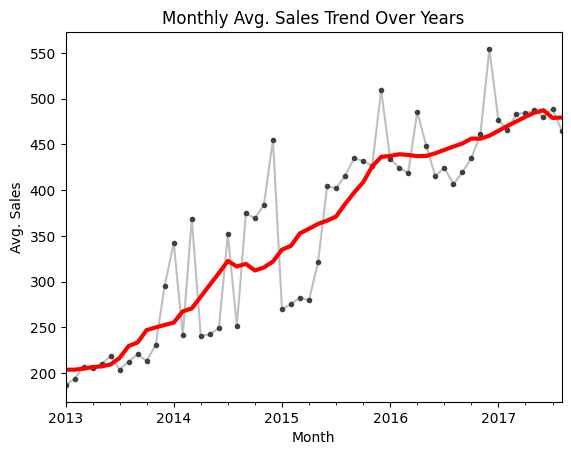

In [10]:
avg_sales = train_eda.resample('M').sales.mean()

moving_avg = avg_sales.rolling(window=12, min_periods=6, center=True).mean()

ax = avg_sales.plot(**plot_params)  
moving_avg.plot(ax=ax, color='red', linewidth=3)
plt.xlabel('Month')
plt.ylabel('Avg. Sales')
plt.title('Monthly Avg. Sales Trend Over Years')
plt.show()


Multiple bend in this monthly moving average suggests that we should try Order 3 polynomial as well.

Just like we used a moving average plot to discover the trend in a series, we can use a seasonal plot to discover seasonal patterns.

In [11]:
def seasonal_plot(X, y, period, freq):
    """
    This definition is to plot seasonal fluctuation in a time series to discover seasonal patterns.
    Inputs:
            X: time series.
            y: target variables 
            period: The period of time series
            freq: The frequency to plot time series for it
    Output:
        Time Series Seasonal Plot    
    """
    _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique())
    ax = sns.lineplot(x=freq, y=y, hue=period, data=X, ax=ax,
                      palette=palette, legend=False, errorbar=('ci', False))  # Updated parameter here
    
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(name, xy=(1, y_), xytext=(6, 0), color=line.get_color(), size=14,
                    xycoords=ax.get_yaxis_transform(), textcoords="offset points", va="center")
        
    return ax


def plot_periodogram(ts):
    """
    This defination is to discover seasonality and plot the periodogram for a time series. 
    """
    
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(ts, fs=fs, detrend='linear', window="boxcar",scaling='spectrum')
    
    _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        ["Annual (1)", "Semiannual (2)", "Quarterly (4)", "Bimonthly (6)", "Monthly (12)",
         "Biweekly (26)", "Weekly (52)", "Semiweekly (104)"], rotation=30)
    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    
    return ax

In [12]:
avg_sales = train_eda.groupby('date')['sales'].mean().to_frame()

# Checking the data types
print(avg_sales.dtypes)



sales    float32
dtype: object


<Axes: title={'center': 'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='sales'>

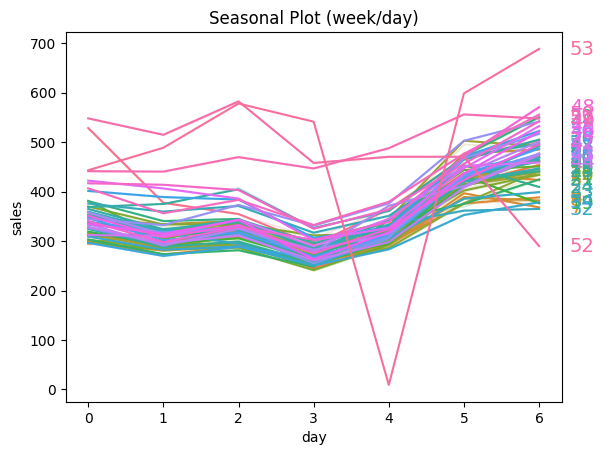

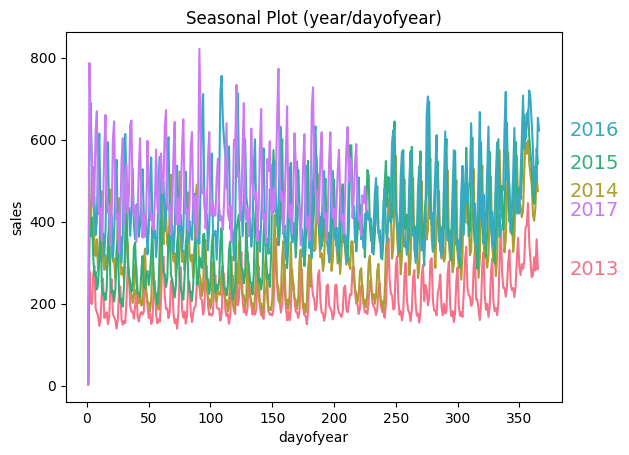

In [13]:
# days within a week
# avg_sales["day"] = avg_sales.index.dayofweek  # the x-axis (freq)
# avg_sales["week"] = avg_sales.index.isocalendar().week

# # days within a year
# avg_sales["dayofyear"] = avg_sales.index.dayofyear
# avg_sales["year"] = avg_sales.index.year

avg_sales['day'] = avg_sales.index.dayofweek.astype('category')
avg_sales['week'] = avg_sales.index.isocalendar().week.astype('category')
avg_sales['dayofyear'] = avg_sales.index.dayofyear.astype('category')
avg_sales['year'] = avg_sales.index.year.astype('category')

seasonal_plot(avg_sales, y=avg_sales['sales'], period="week", freq="day")
seasonal_plot(avg_sales, y=avg_sales['sales'], period="year", freq="dayofyear")


# Modeling

** Cross Validation

Time series can be either univariate or multivariate:

Univariate time series only has a single time-dependent variable.
Multivariate time series have a multiple time-dependent variable.
But, first of all we are going to see how does cross validation technic works in TimeSeries Analysis.

In [14]:
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

comp_dir = Path('../input/store-sales-time-series-forecasting')
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

/tmp/ipykernel_32/1629373035.py:9: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(


For now, we'll just work with a single series - the average sales each day.

**Fit a time-step feature
**

Creating a linear regression model with a time-step feature on the series of average product sales. The target is in a column called 'sales'.

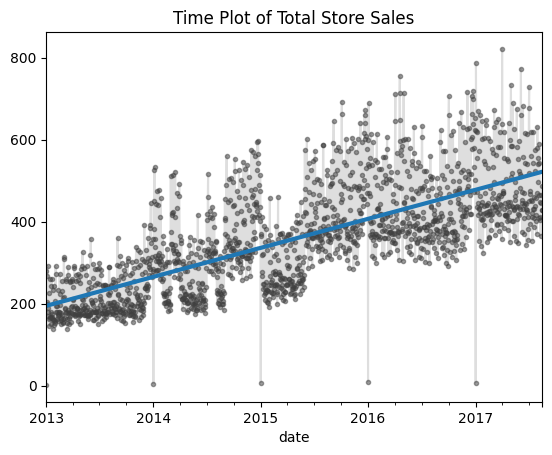

In [15]:
from sklearn.linear_model import LinearRegression

df = average_sales.to_frame()

df.head()

time = np.arange(len(df.index))

df['time'] = time 

X = df.loc[:,['time']]
y = df['sales']


model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

**Now we will fit a lag feature to Store Sales**

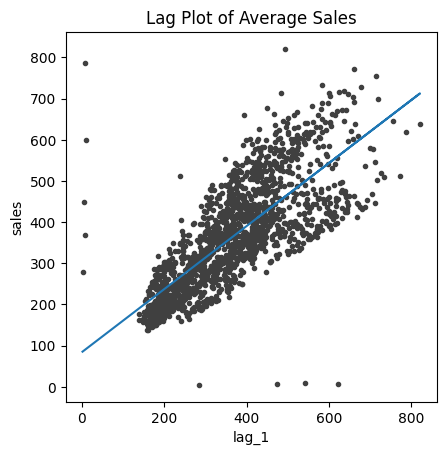

In [16]:
df = average_sales.to_frame()


lag_1 = df['sales'].shift(1)
df['lag_1'] = lag_1  # add to dataframe

X = df.loc[:, ['lag_1']].dropna()
y = df.loc[:, 'sales']  
y, X = y.align(X, join='inner')  

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

# Model Trend

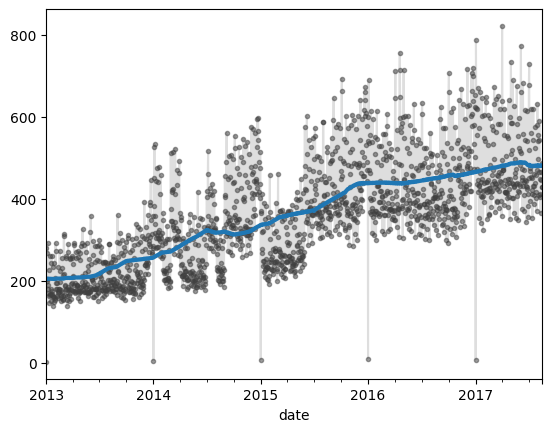

In [17]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

Now I will use`DeterministicProcess` to create a feature set for a cubic trend model. Also create features for a 90-day forecast.

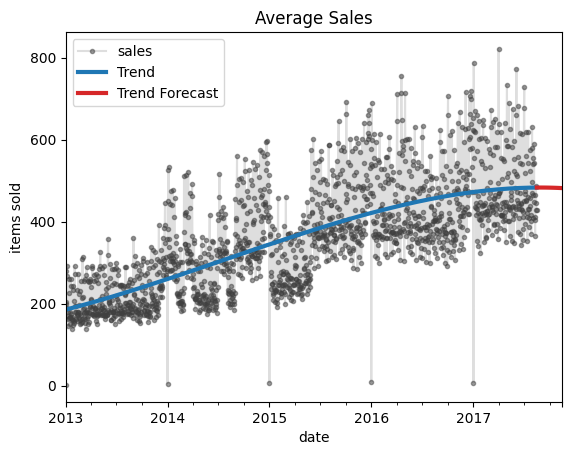

In [18]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy() 

dp = DeterministicProcess(
    index=y.index,
    order=3,
    drop=True,)

X = dp.in_sample()

X_fore = dp.out_of_sample(steps=90)

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

**Let's try fitting order 2 polynomial.**

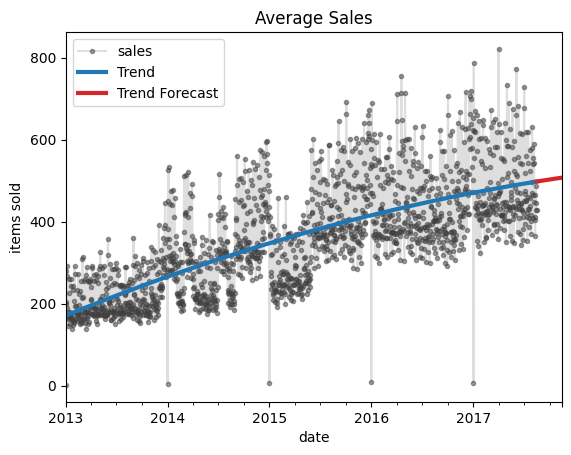

In [19]:
y = average_sales.copy() 

dp = DeterministicProcess(
    index=y.index,
    order=2,
    drop=True,)

X = dp.in_sample()

X_fore = dp.out_of_sample(steps=90)

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

**And Order = 4**

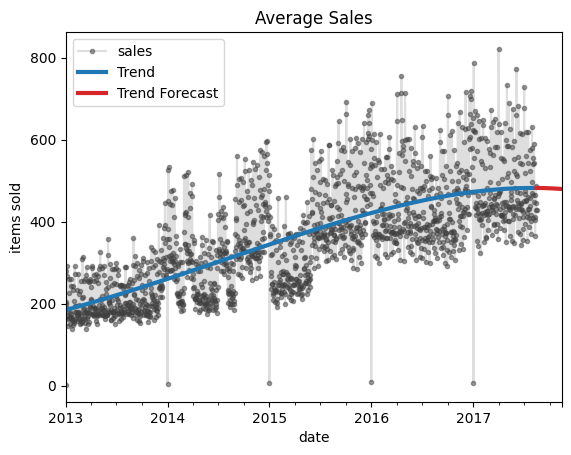

In [20]:
y = average_sales.copy() 

dp = DeterministicProcess(
    index=y.index,
    order=4,
    drop=True,)

X = dp.in_sample()

X_fore = dp.out_of_sample(steps=90)

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

# Model Seosanality

In [21]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [22]:
comp_dir = Path('../input/store-sales-time-series-forecasting')

holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

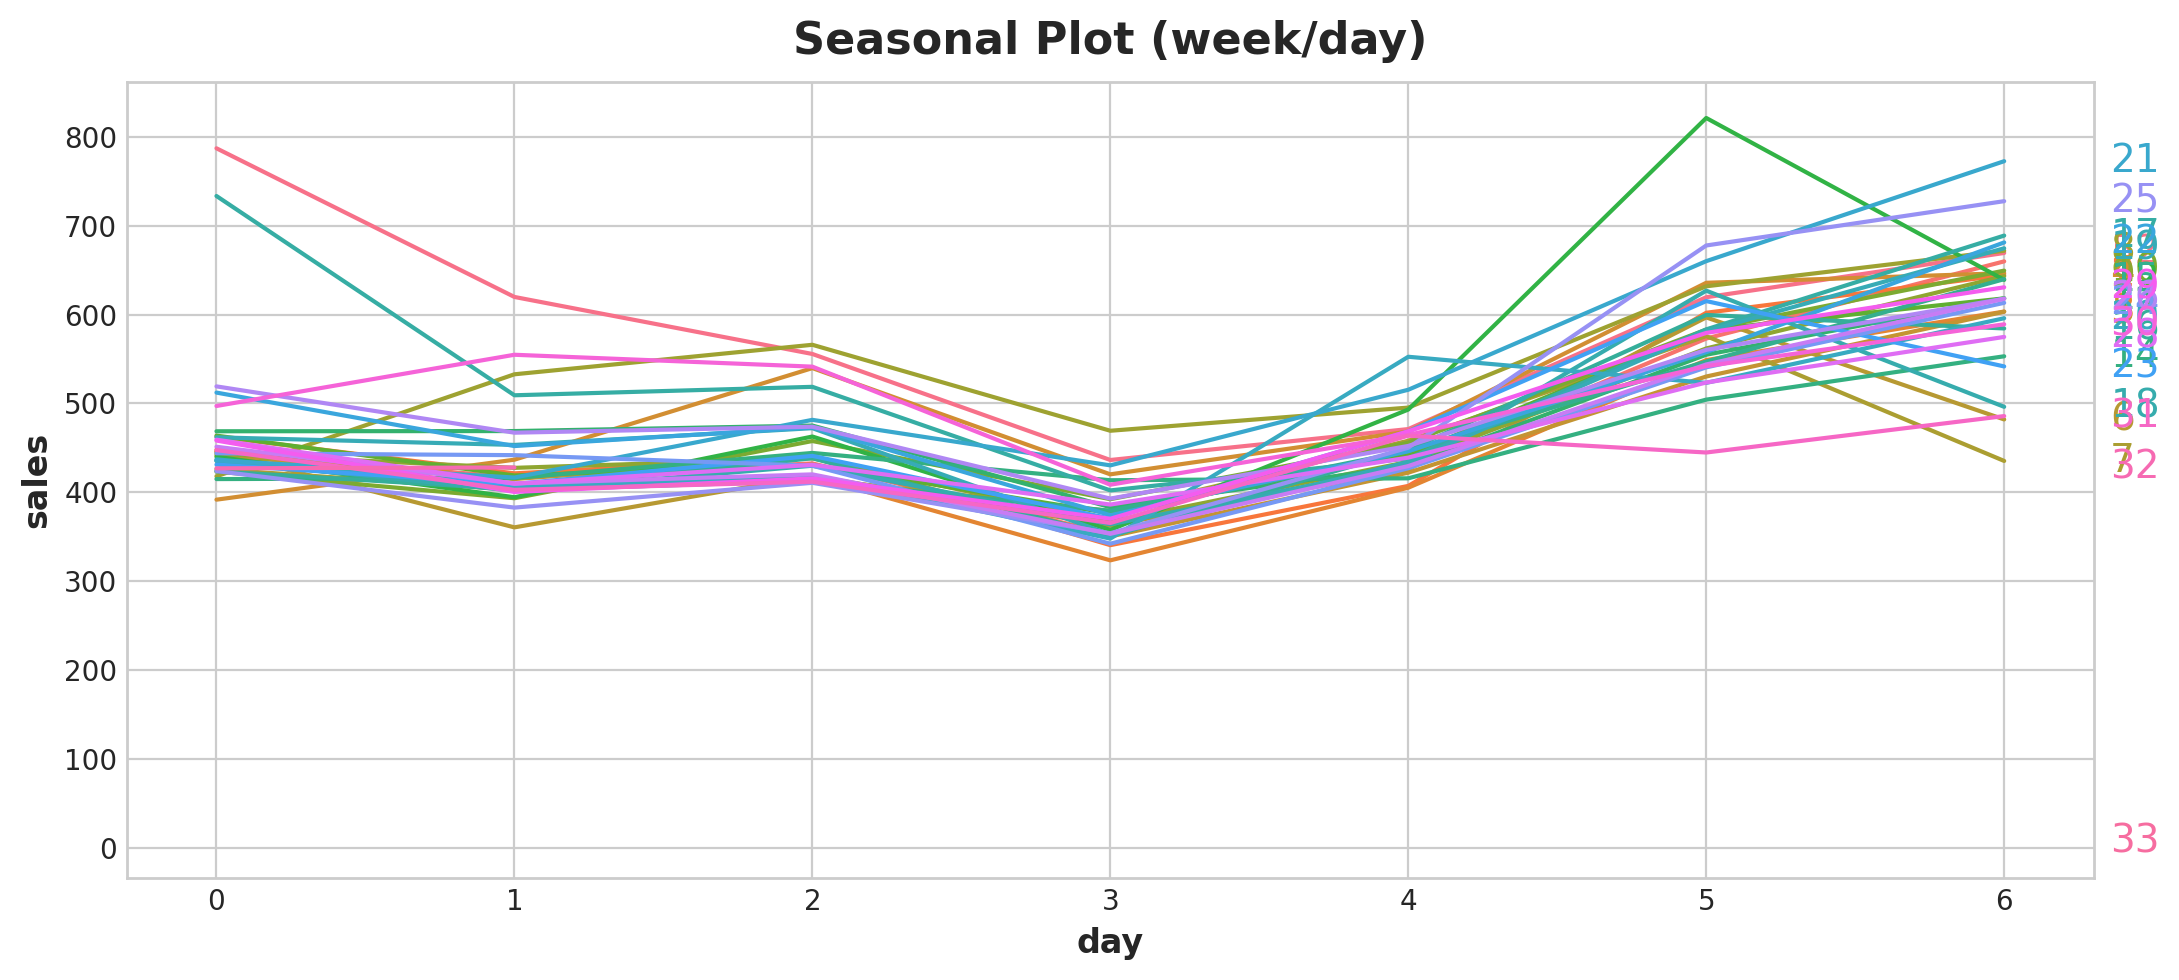

In [23]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

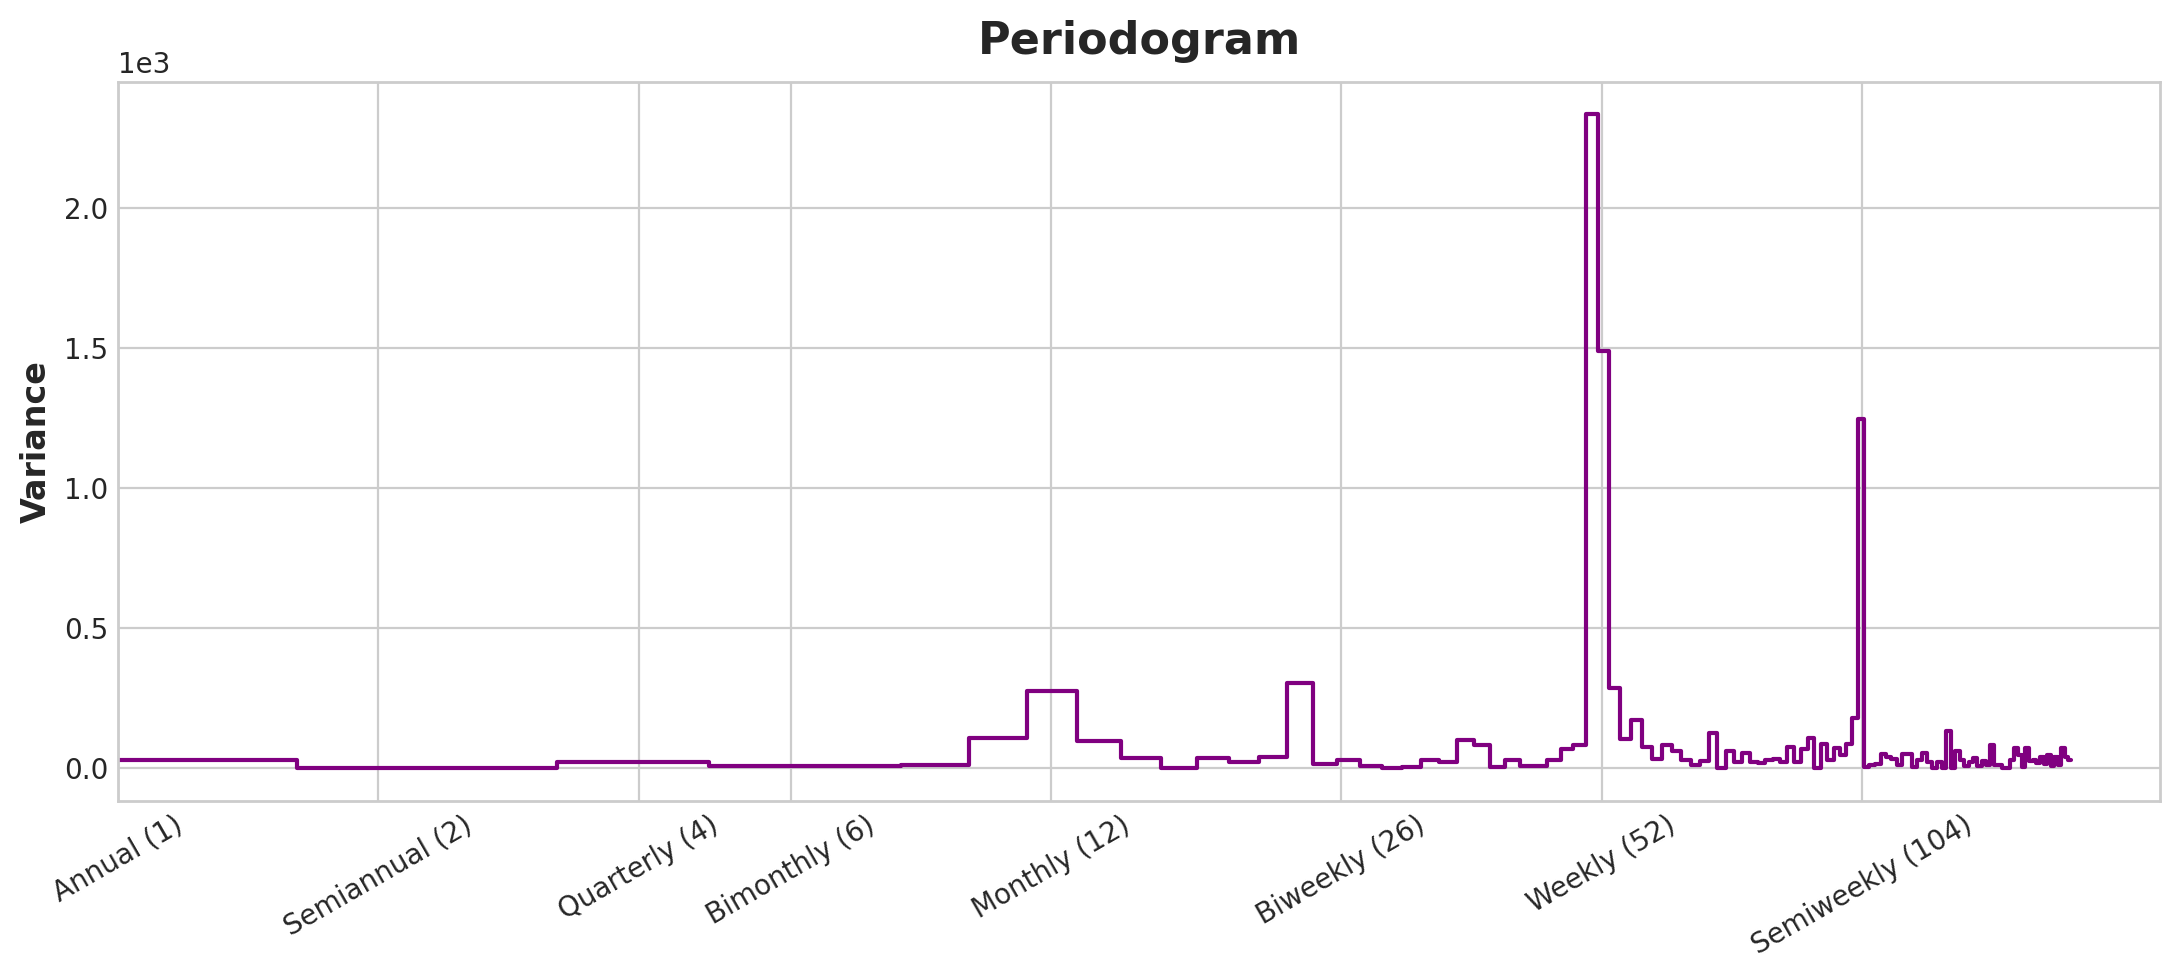

In [24]:
plot_periodogram(average_sales);

**From the periodogram, it appears there may be some monthly and biweekly components as well. In fact, the notes to the Store Sales dataset say wages in the public sector are paid out biweekly, on the 15th and last day of the month -- a possible origin for these seasons.**

Now I will use DeterministicProcess and CalendarFourier to create:

* indicators for weekly seasons and
* Fourier features of order 4 for monthly seasons.

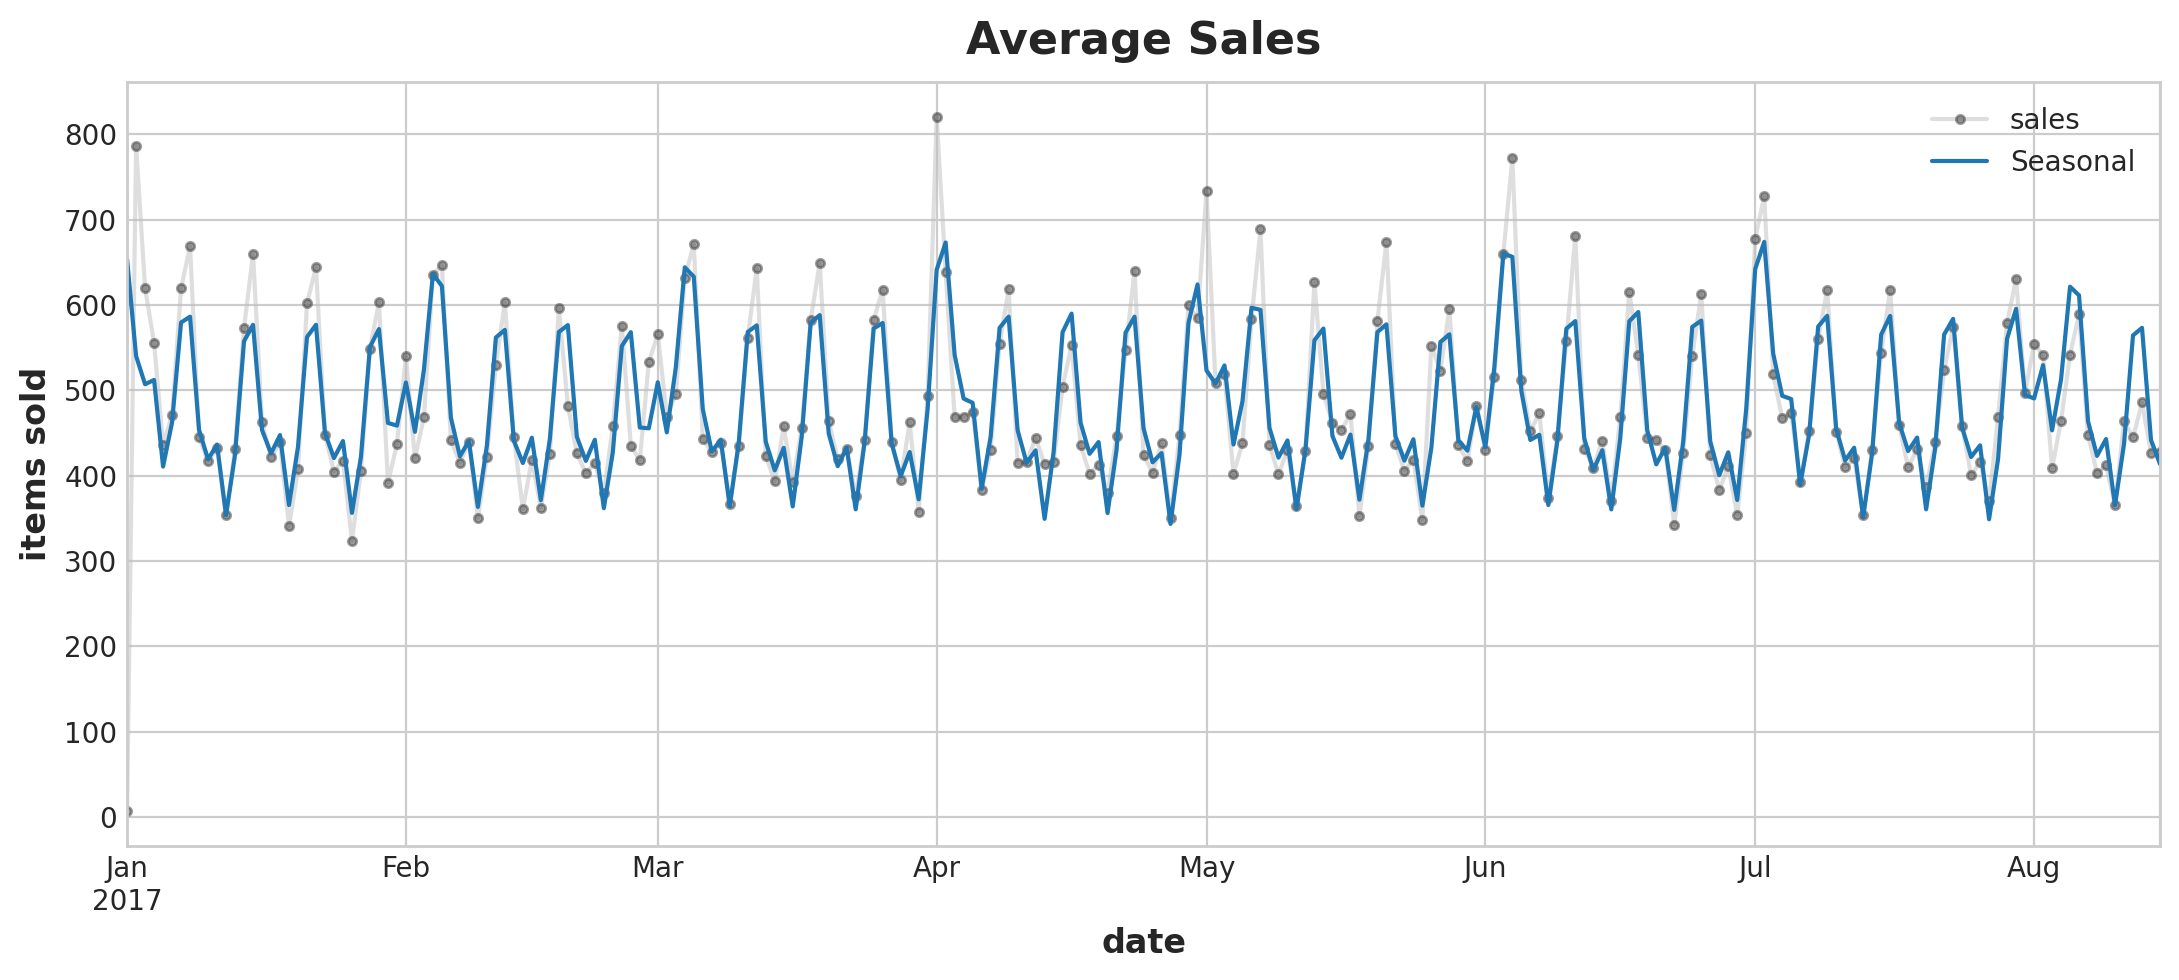

In [25]:
y = average_sales.copy()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

Removing from a series its trend or seasons is called **detrending** or **deseasonalizing** the series.

**The periodogram of the deseasonalized series.**


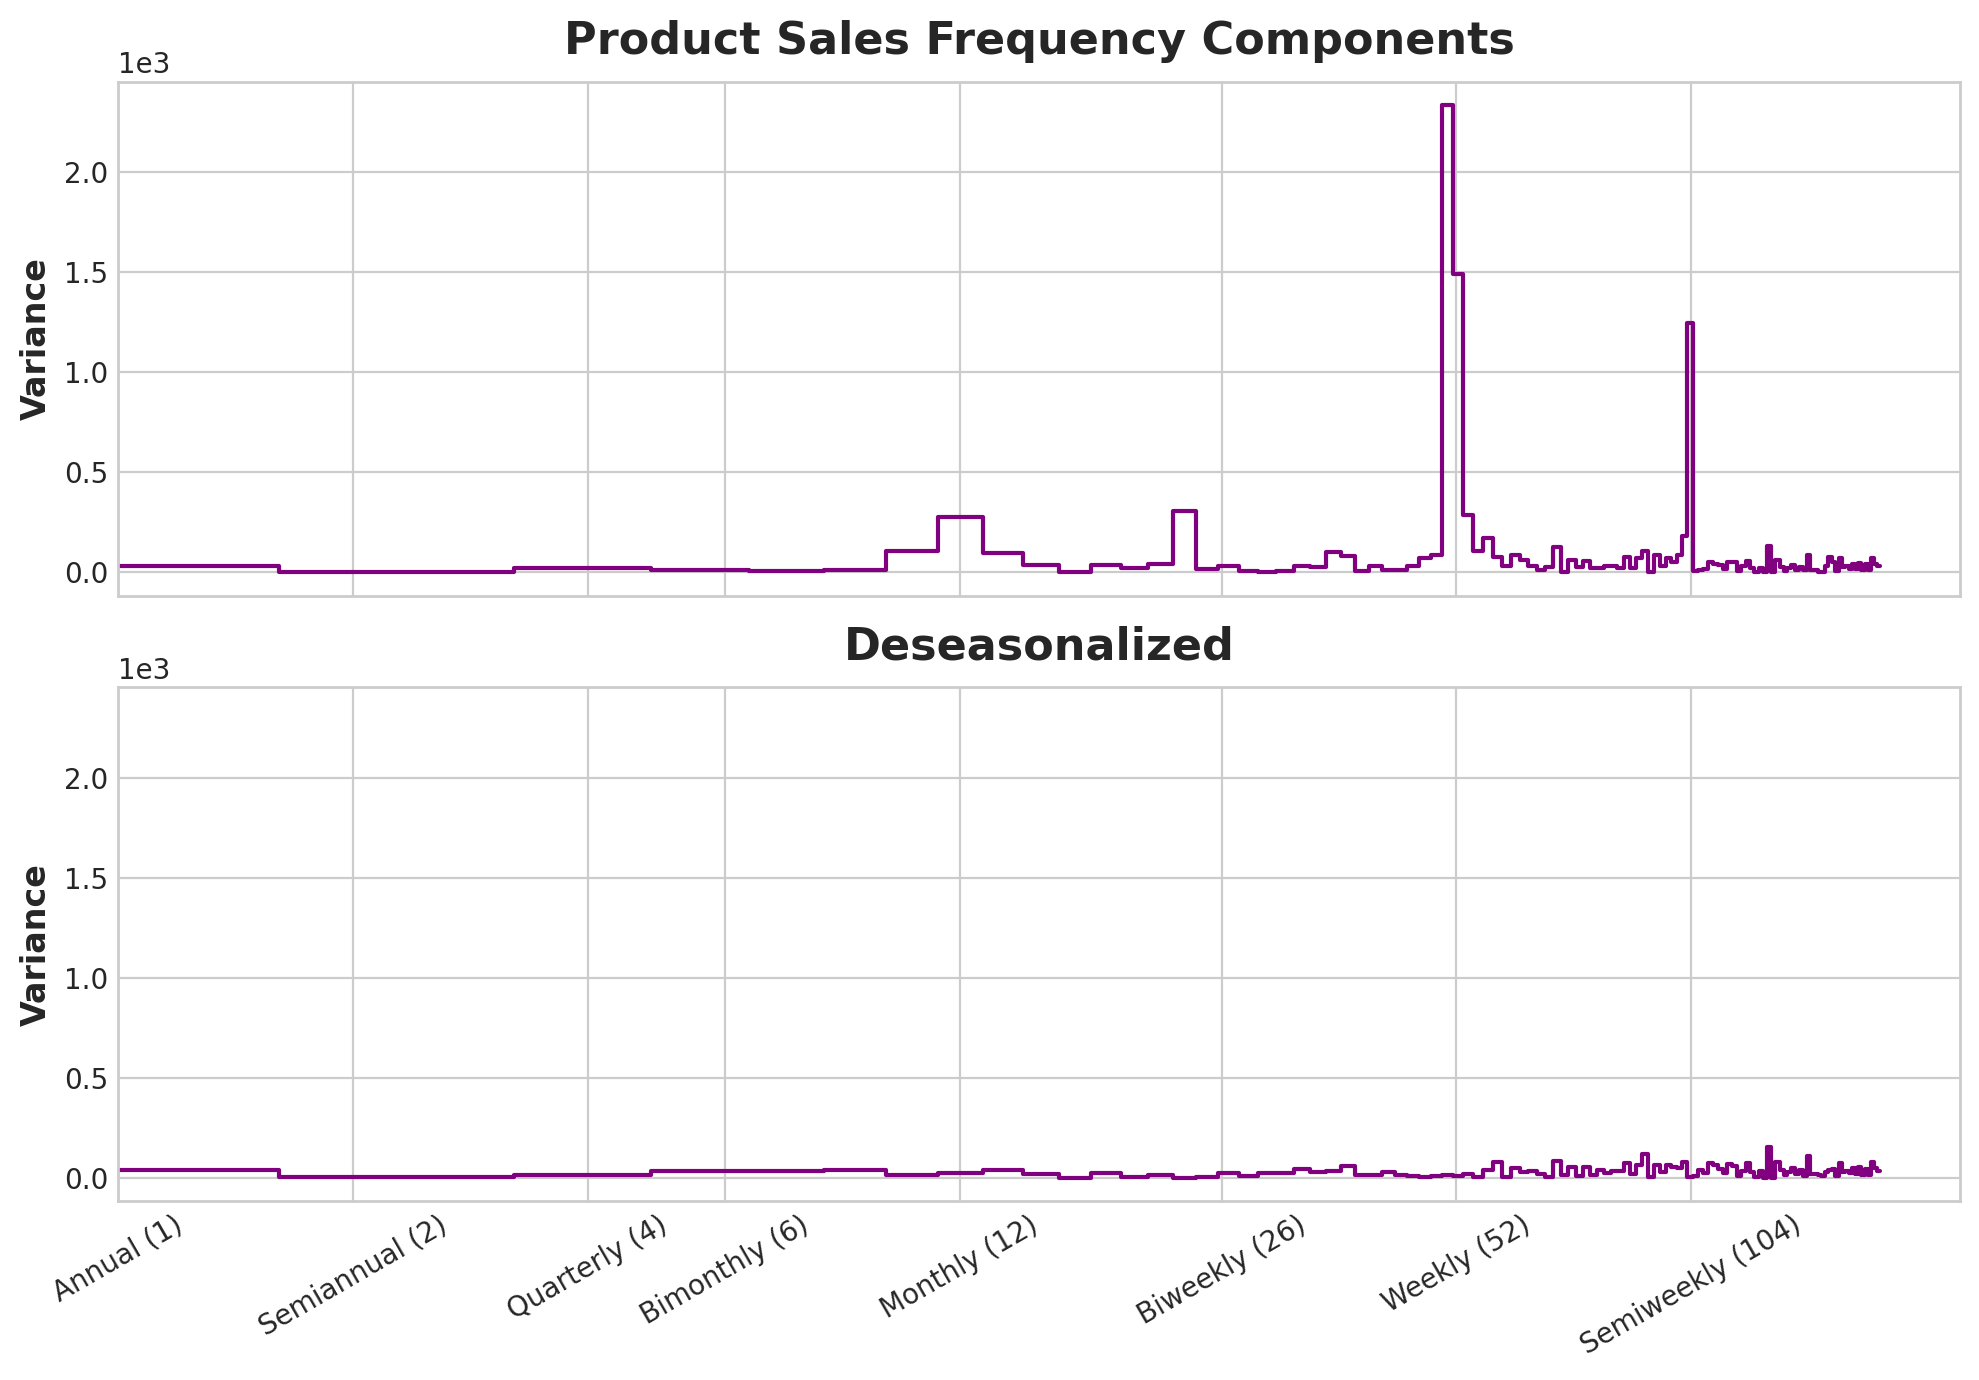

In [26]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

**The periodogram for the deseasonalized series lacks any large values. By comparing it to the periodogram for the original series, we can see that our model was able to capture the seasonal variation in Average Sales.**

**From a plot of the deseasonalized *Average Sales*, it appears these holidays could have some predictive power.**

In [27]:
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

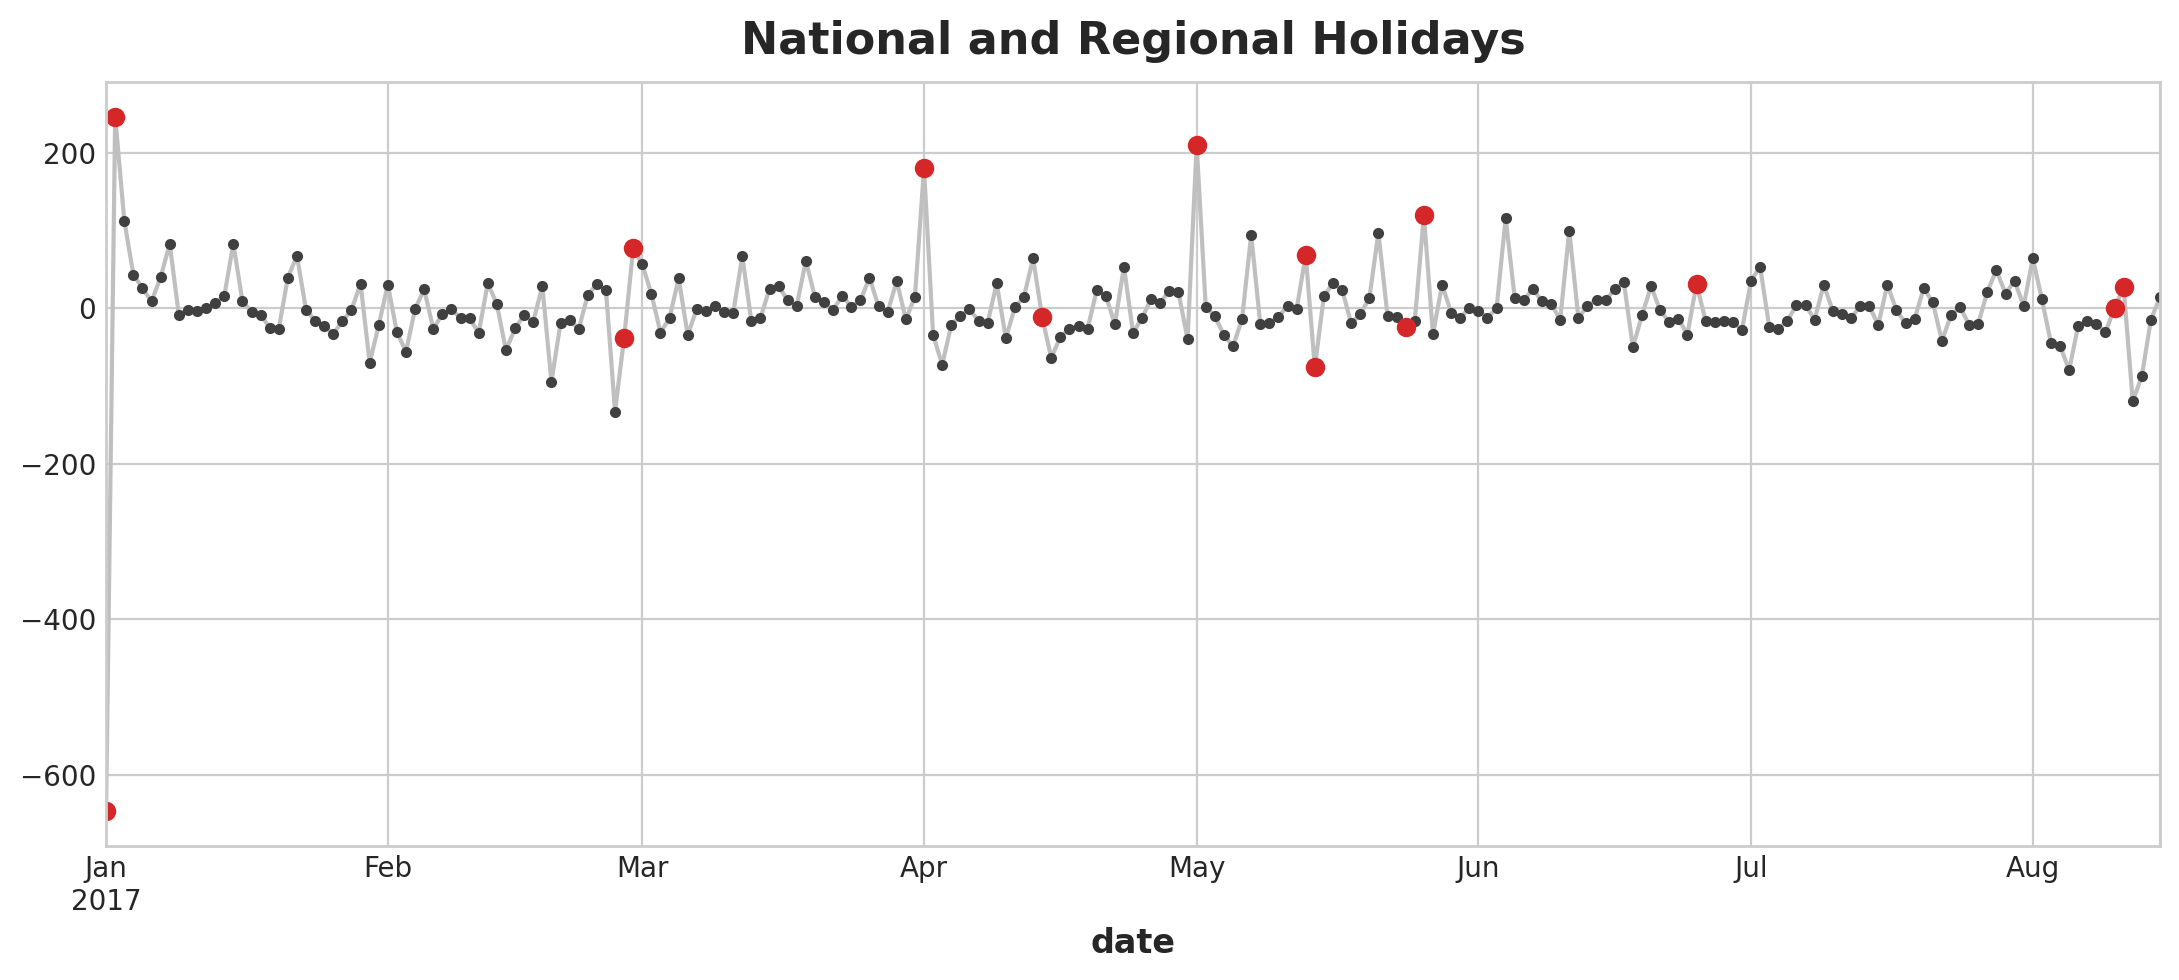

In [28]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

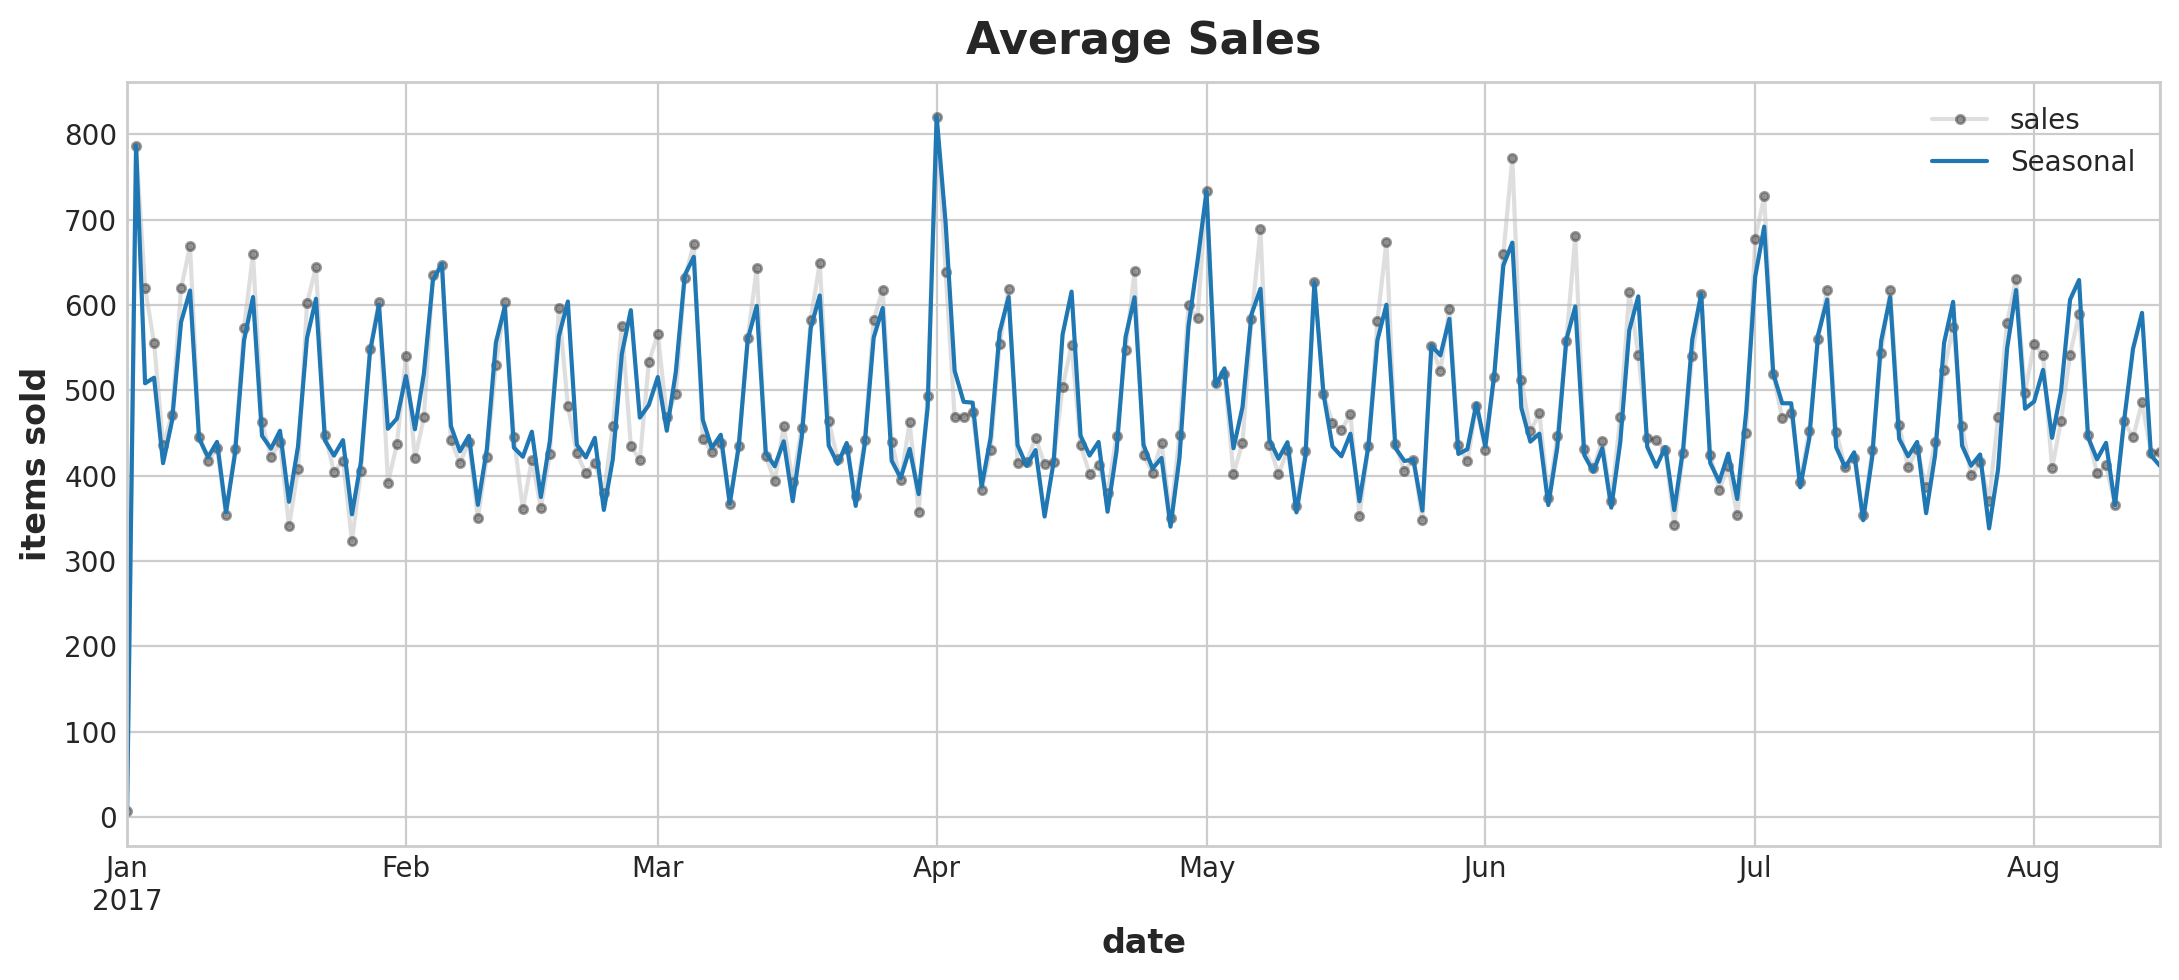

In [29]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
X_holidays = pd.DataFrame(
    ohe.fit_transform(holidays),
    index=holidays.index,
    columns=holidays.description.unique(),
)

X_holidays = pd.get_dummies(holidays)
X2 = X.join(X_holidays, on='date').fillna(0.0)

model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

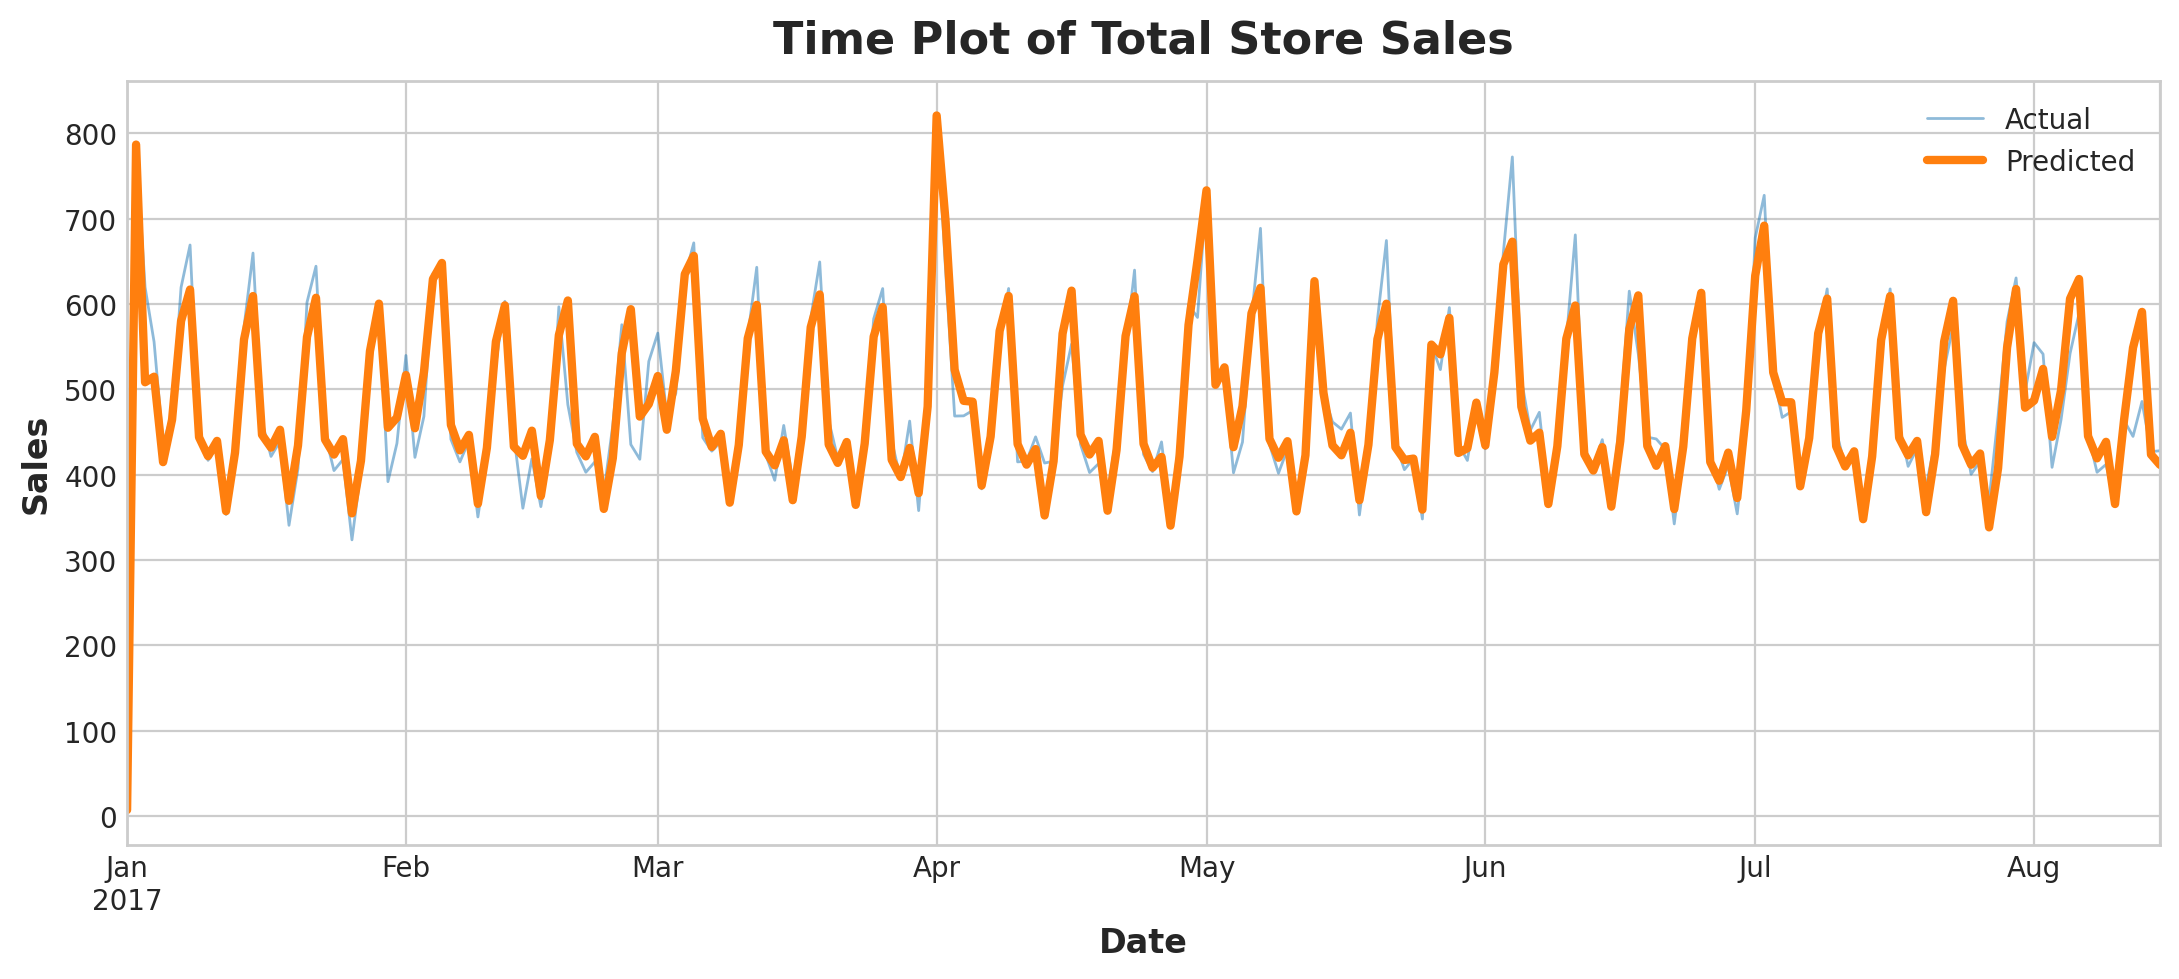

In [30]:
# Create a time plot of actual and predicted sales
ax = y.plot(alpha=0.5, label='Actual', linewidth=1)
y_pred.plot(ax=ax, label='Predicted', linewidth=3)

# Set the title and labels
ax.set_title('Time Plot of Total Store Sales')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

# Show the legend
ax.legend()

# Show the plot
plt.show()

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
# MAPE requires handling of zero actual sales to avoid division by zero errors
mape = np.mean(np.abs((y - y_pred) / y).replace(np.inf, np.nan)) * 100
r2 = r2_score(y, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R-squared: {r2}')


MAE: 22.24838863880252
MSE: 1042.6778245806343
RMSE: 32.290522209785244
MAPE: 4.580230784762814
R-squared: 0.8975121424106105


* MAE (22.25): The model's predictions are, on average, 22.25 units off from the actual sales values.
* MSE (1042.68): Indicates the average squared difference between the predicted and actual values, with a higher emphasis on larger errors.
* RMSE (32.29): The standard deviation of the model's prediction errors, averaging 32.29 units from the actual sales.
* MAPE (4.58%): The model's predictions deviate from the actual values by an average of 4.58%, showing the error as a percentage of actual sales.
* R-squared (0.898): 89.8% of the variability in actual sales is explained by the model, indicating a strong fit to the data.**

In [32]:
comp_dir = Path('../input/store-sales-time-series-forecasting')

holidays_events = pd.read_csv(
    comp_dir / 'holidays_events.csv'
)

In [33]:
holidays_events.head()

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [34]:
holidays_events.describe()

date     type    locale locale_name description transferred
count          350      350       350         350         350         350
unique         312        6         3          24         103           2
top     2014-06-25  Holiday  National     Ecuador    Carnaval       False
freq             4      221       174         174          10         338

In [35]:
# Check for missing values in the dataset
missing_values = holidays_events.isnull().sum()

# Summary statistics for the dataset
summary = holidays_events.describe(include='all')

# Date range
date_range = holidays_events['date'].agg(['min', 'max'])

# Understanding the distribution of types of events and locales
event_type_distribution = holidays_events['type'].value_counts()
locale_distribution = holidays_events['locale'].value_counts()
locale_name_distribution = holidays_events['locale_name'].value_counts()
description_distribution = holidays_events['description'].value_counts()

# Checking for duplicates in the dates
duplicate_dates = holidays_events['date'].duplicated().sum()

missing_values, summary, date_range, event_type_distribution, locale_distribution,locale_name_distribution, description_distribution


(date           0
 type           0
 locale         0
 locale_name    0
 description    0
 transferred    0
 dtype: int64,
               date     type    locale locale_name description transferred
 count          350      350       350         350         350         350
 unique         312        6         3          24         103           2
 top     2014-06-25  Holiday  National     Ecuador    Carnaval       False
 freq             4      221       174         174          10         338,
 min    2012-03-02
 max    2017-12-26
 Name: date, dtype: object,
 type
 Holiday       221
 Event          56
 Additional     51
 Transfer       12
 Bridge          5
 Work Day        5
 Name: count, dtype: int64,
 locale
 National    174
 Local       152
 Regional     24
 Name: count, dtype: int64,
 locale_name
 Ecuador                           174
 Quito                              13
 Riobamba                           12
 Guaranda                           12
 Latacunga                     

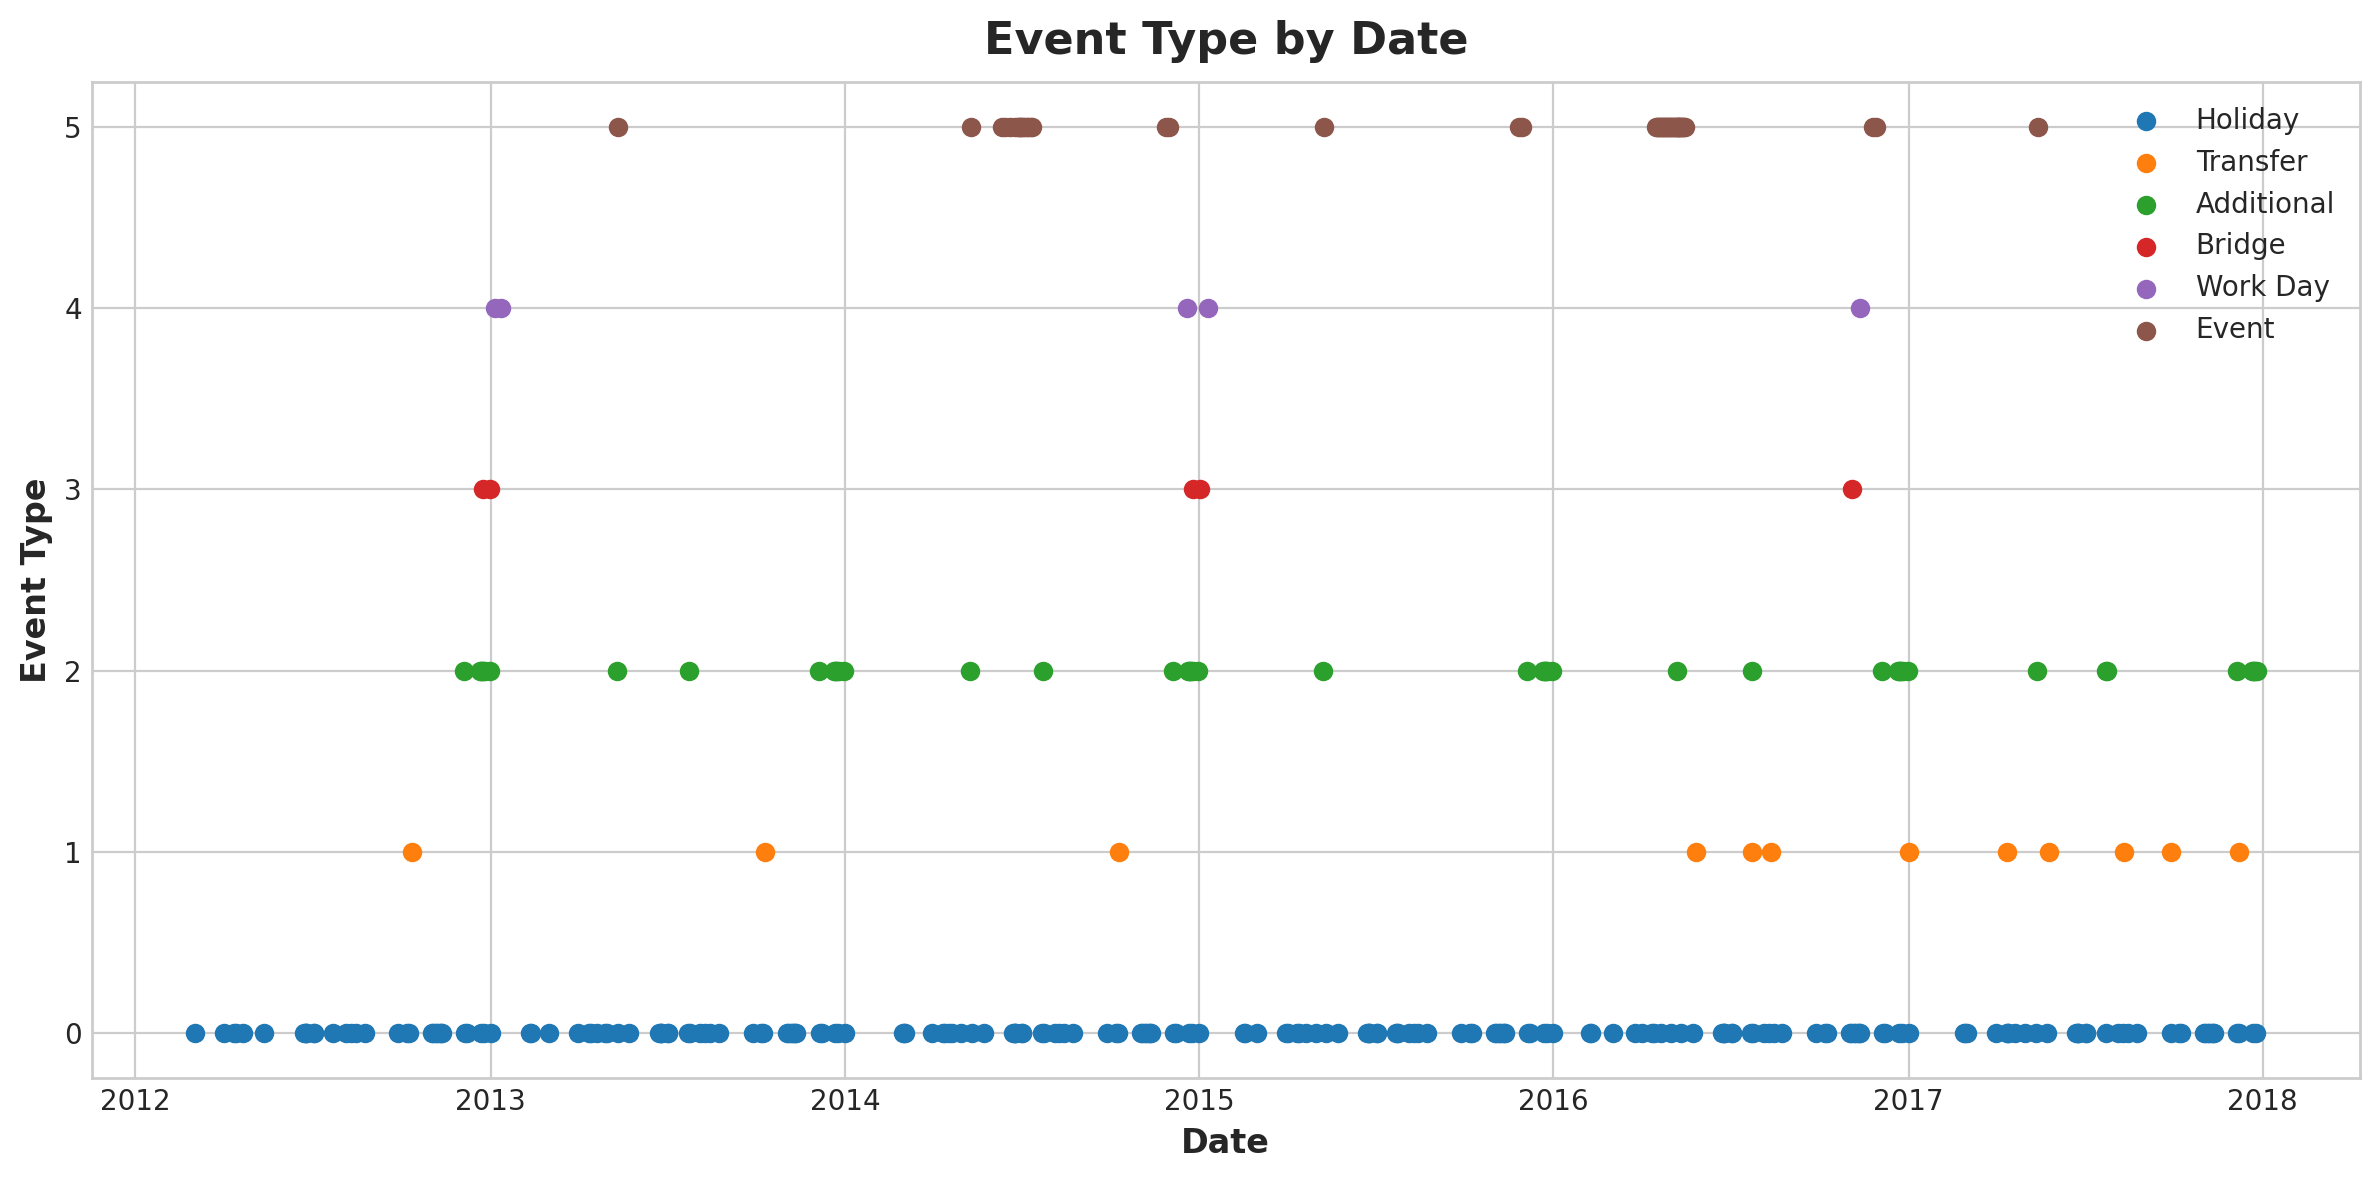

In [36]:
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

# Create a color mapping for each type
type_colors = {type_name: i for i, type_name in enumerate(holidays_events['type'].unique())}

# Plot each day, colored by type
plt.figure(figsize=(12, 6))
for type_name, color in type_colors.items():
    type_dates = holidays_events[holidays_events['type'] == type_name]['date']
    plt.scatter(type_dates, [color] * len(type_dates), label=type_name)

plt.legend()
plt.xlabel('Date')
plt.ylabel('Event Type')
plt.title('Event Type by Date')
plt.show()


Some Observations:

* Year 2016 and 2017 have more Transfers than the other years.
* 2012-2016 have one transfer each, from visual inspection it looks like its the same day, we will have to do more analysis to make sure.
* Holidays, Additional seems like the same number throughout each of the years.
* Bridge and work day is available in only 3 years.

In [37]:
import pandas as pd

holidays_events['date'] = pd.to_datetime(holidays_events['date'])
holidays_events['year'] = holidays_events['date'].dt.year

type_by_year_count = holidays_events.groupby(['year', 'type']).size().unstack(fill_value=0)

type_by_year_table = pd.DataFrame(type_by_year_count).reset_index()

print(type_by_year_table)

type  year  Additional  Bridge  Event  Holiday  Transfer  Work Day
0     2012           7       2      0       31         1         0
1     2013           9       0      1       38         1         2
2     2014           9       1     17       38         1         1
3     2015           8       1      3       39         0         1
4     2016           9       1     34       38         3         1
5     2017           9       0      1       37         6         0


* Year 2016 and 2017 have Indeed more Transfers than the other years. More specifically 2012-2014 have only one transfer per year, will now check if its the same day of each of the year.
* Holidays, Additional indeed almost the same number throughout each of the years. Will now check if these are the same dates per year.
* Bridge is available for 4 years, one year has 2 times and others are just 1 time each, Neet to inspect further.
* Work day count is same as Bridge, need to inspect further.
* In 2014 and 2016 the events counts are larger, is there any underlying reasons? What is the max and min date for events on those years?

In [38]:
# Filter for 'Transfer' type and group by 'year'
transfer_dates_by_year = holidays_events[holidays_events['type'] == 'Transfer'].groupby('year')['date']

# Print the dates for each year
for year, dates in transfer_dates_by_year:
    print(f"Year {year} Transfer Dates:")
    print(dates.dt.strftime('%Y-%m-%d').tolist())
    print()  # Print a newline for better readability

Year 2012 Transfer Dates:
['2012-10-12']

Year 2013 Transfer Dates:
['2013-10-11']

Year 2014 Transfer Dates:
['2014-10-10']

Year 2016 Transfer Dates:
['2016-05-27', '2016-07-24', '2016-08-12']

Year 2017 Transfer Dates:
['2017-01-02', '2017-04-13', '2017-05-26', '2017-08-11', '2017-09-29', '2017-12-08']



* 2012-2014 the Transfer dates are indeed close to the same date. October 12th, 11th, 10th.
* 2016-2017 : two dates are close to each other : May 26th and May 27th, August 12th and August 11th.

In [39]:
# Filter for 'Bridgetype and group by 'year'
transfer_dates_by_year = holidays_events[holidays_events['type'] == 'Bridge'].groupby('year')['date']

# Print the dates for each year
for year, dates in transfer_dates_by_year:
    print(f"Year {year} Bridge Dates:")
    print(dates.dt.strftime('%Y-%m-%d').tolist())
    print()  # Print a newline for better readability

Year 2012 Bridge Dates:
['2012-12-24', '2012-12-31']

Year 2014 Bridge Dates:
['2014-12-26']

Year 2015 Bridge Dates:
['2015-01-02']

Year 2016 Bridge Dates:
['2016-11-04']



Bridge dates are confined within the months November to January. The first 2 years have the Bridges only in December.

In [40]:
# Filter for 'Work Day and group by 'year'
transfer_dates_by_year = holidays_events[holidays_events['type'] == 'Work Day'].groupby('year')['date']

# Print the dates for each year
for year, dates in transfer_dates_by_year:
    print(f"Year {year} Work Day Dates:")
    print(dates.dt.strftime('%Y-%m-%d').tolist())
    print()  # Print a newline for better readability

Year 2013 Work Day Dates:
['2013-01-05', '2013-01-12']

Year 2014 Work Day Dates:
['2014-12-20']

Year 2015 Work Day Dates:
['2015-01-10']

Year 2016 Work Day Dates:
['2016-11-12']



Analysis of Dates:

* In 2013, there are two 'Work Day' dates in early January, which may suggest a payback for extended holidays taken at the end of 2012.
* For 2014, there is a single 'Work Day' in late December, hinting at a possible payback for a 'Bridge' day taken earlier.
* In 2015, the 'Work Day' occurs in early January, possibly related to the New Year's holiday.
* The year 2016 shows a 'Work Day' in November, which could correlate with a 'Bridge' day taken around that time.

* Timing Relative to Holidays: 'Work Day' events seem to be strategically placed around existing holidays or at the beginning of the year, which may compensate for 'Bridge' days that extend holiday periods.

* Connection with Bridge Days: There is a potential correlation between the occurrence of 'Bridge' and 'Work Day' events. This is expected as 'Bridge' days are typically compensated by 'Work Days', where a non-working day is turned into a working day to make up for the work hours lost due to the 'Bridge' day.

In [41]:
work_days = holidays_events[holidays_events['type'] == 'Work Day']
bridge_days = holidays_events[holidays_events['type'] == 'Bridge']

# Create a list to hold DataFrames for each year
comparison_list = []

# Get unique years
years = sorted(holidays_events['year'].unique())

# Populate the comparison list with DataFrames for each year
for year in years:
    work_day_dates = work_days[work_days['year'] == year]['date'].dt.strftime('%Y-%m-%d').tolist()
    bridge_day_dates = bridge_days[bridge_days['year'] == year]['date'].dt.strftime('%Y-%m-%d').tolist()
    
    year_df = pd.DataFrame({
        'Year': [year],
        'Work Day Dates': [work_day_dates],
        'Bridge Day Dates': [bridge_day_dates]
    })
    
    comparison_list.append(year_df)

# Concatenate all DataFrames in the list to create the final comparison DataFrame
comparison_df = pd.concat(comparison_list, ignore_index=True)

# Print or save the comparison DataFrame
print(comparison_df)

   Year            Work Day Dates          Bridge Day Dates
0  2012                        []  [2012-12-24, 2012-12-31]
1  2013  [2013-01-05, 2013-01-12]                        []
2  2014              [2014-12-20]              [2014-12-26]
3  2015              [2015-01-10]              [2015-01-02]
4  2016              [2016-11-12]              [2016-11-04]
5  2017                        []                        []


2012 does not have word day dates because we have data from March of 2012.
Other than 2016 and 2017, it seems that if the number of bridge days of previous year is the same number of work days in the following year.


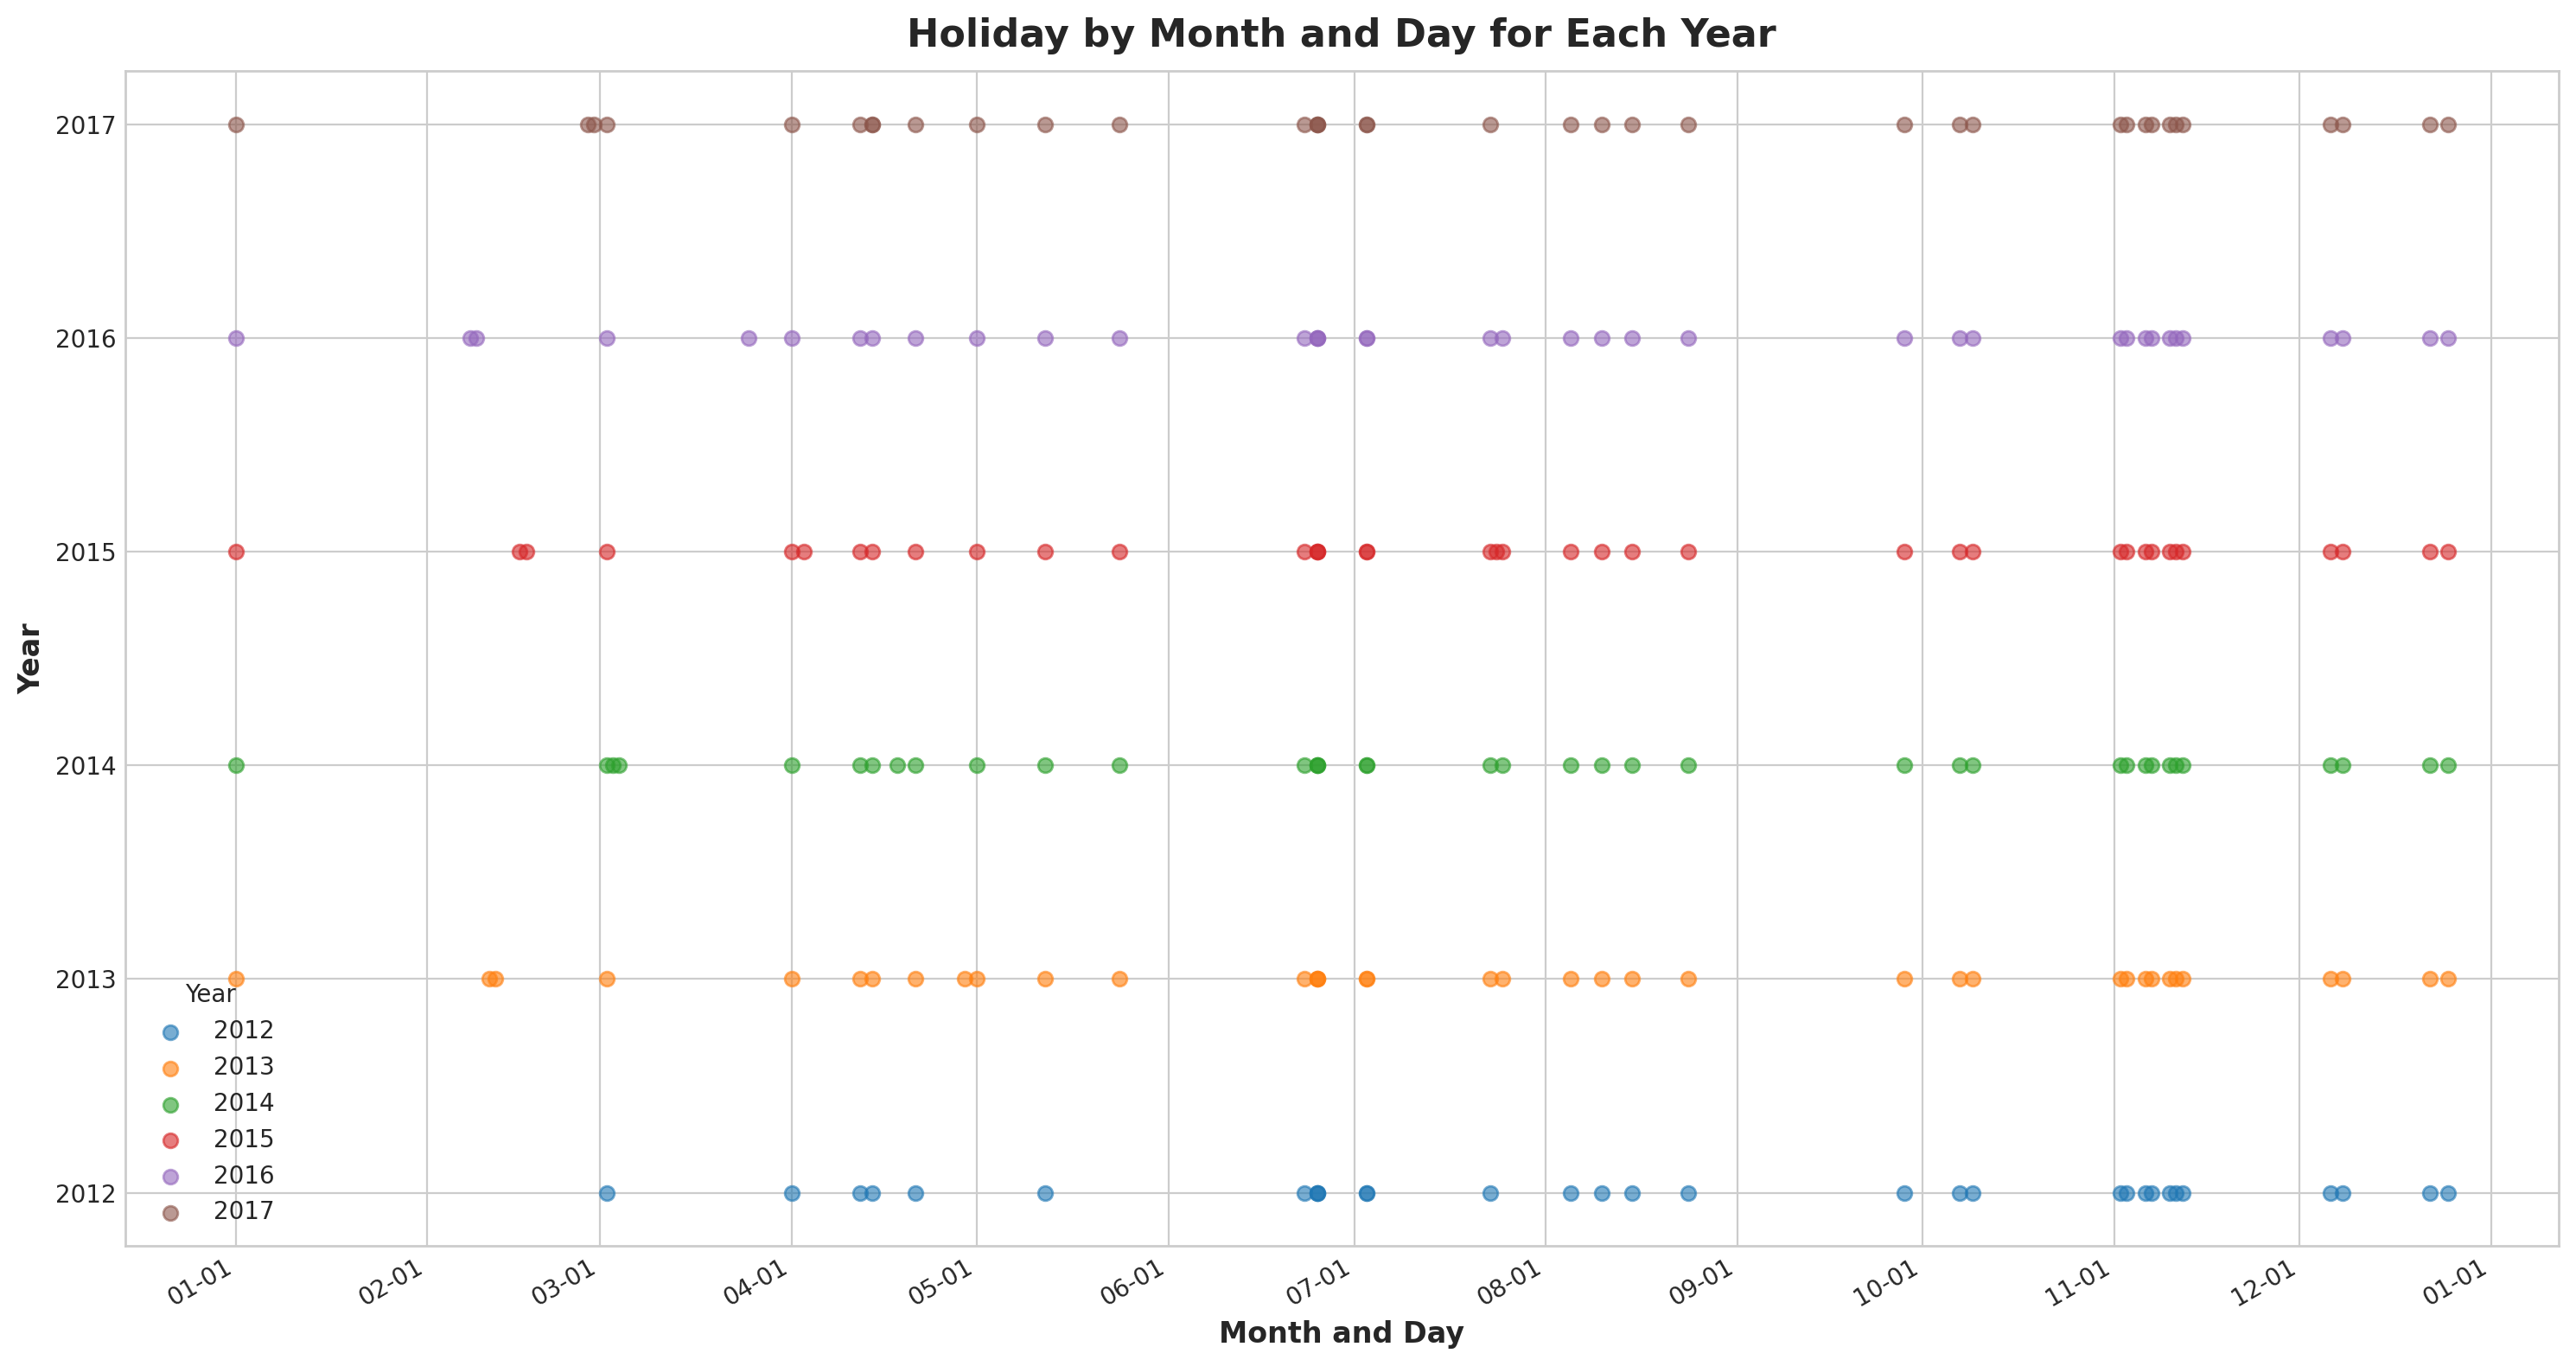

In [42]:
import matplotlib.dates as mdates


# Filter out the data for 'Holiday' and 'Additional' types
holiday_additional_data = holidays_events[
    holidays_events['type'].isin(['Holiday'])
].copy()

# Convert 'date' to datetime and create 'month_day' column for plotting
holiday_additional_data['date'] = pd.to_datetime(holiday_additional_data['date'])
holiday_additional_data['month_day'] = holiday_additional_data['date'].dt.strftime('%m-%d')  # MM-DD format

# Create a scatter plot
plt.figure(figsize=(15, 8))

# Plot each year's data with a different marker and/or color
for year in sorted(holiday_additional_data['year'].unique()):
    # Filter data for the year
    yearly_data = holiday_additional_data[holiday_additional_data['year'] == year]
    
    # Convert 'month_day' back to datetime just for plotting purposes
    dates = pd.to_datetime(yearly_data['month_day'], format='%m-%d')
    
    # Plot the data, using day of the year for x and year for y
    plt.scatter(dates, [year] * len(dates), label=year, alpha=0.6)

# Improve formatting and layout
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Rotate date labels
plt.legend(title='Year')
plt.xlabel('Month and Day')
plt.ylabel('Year')
plt.title('Holiday by Month and Day for Each Year')
plt.grid(True)
plt.show()

This plot shows that Holidays are mostly consistent for every year. Now we should inspect if there is a pattern in sales following holidays for each of the year.

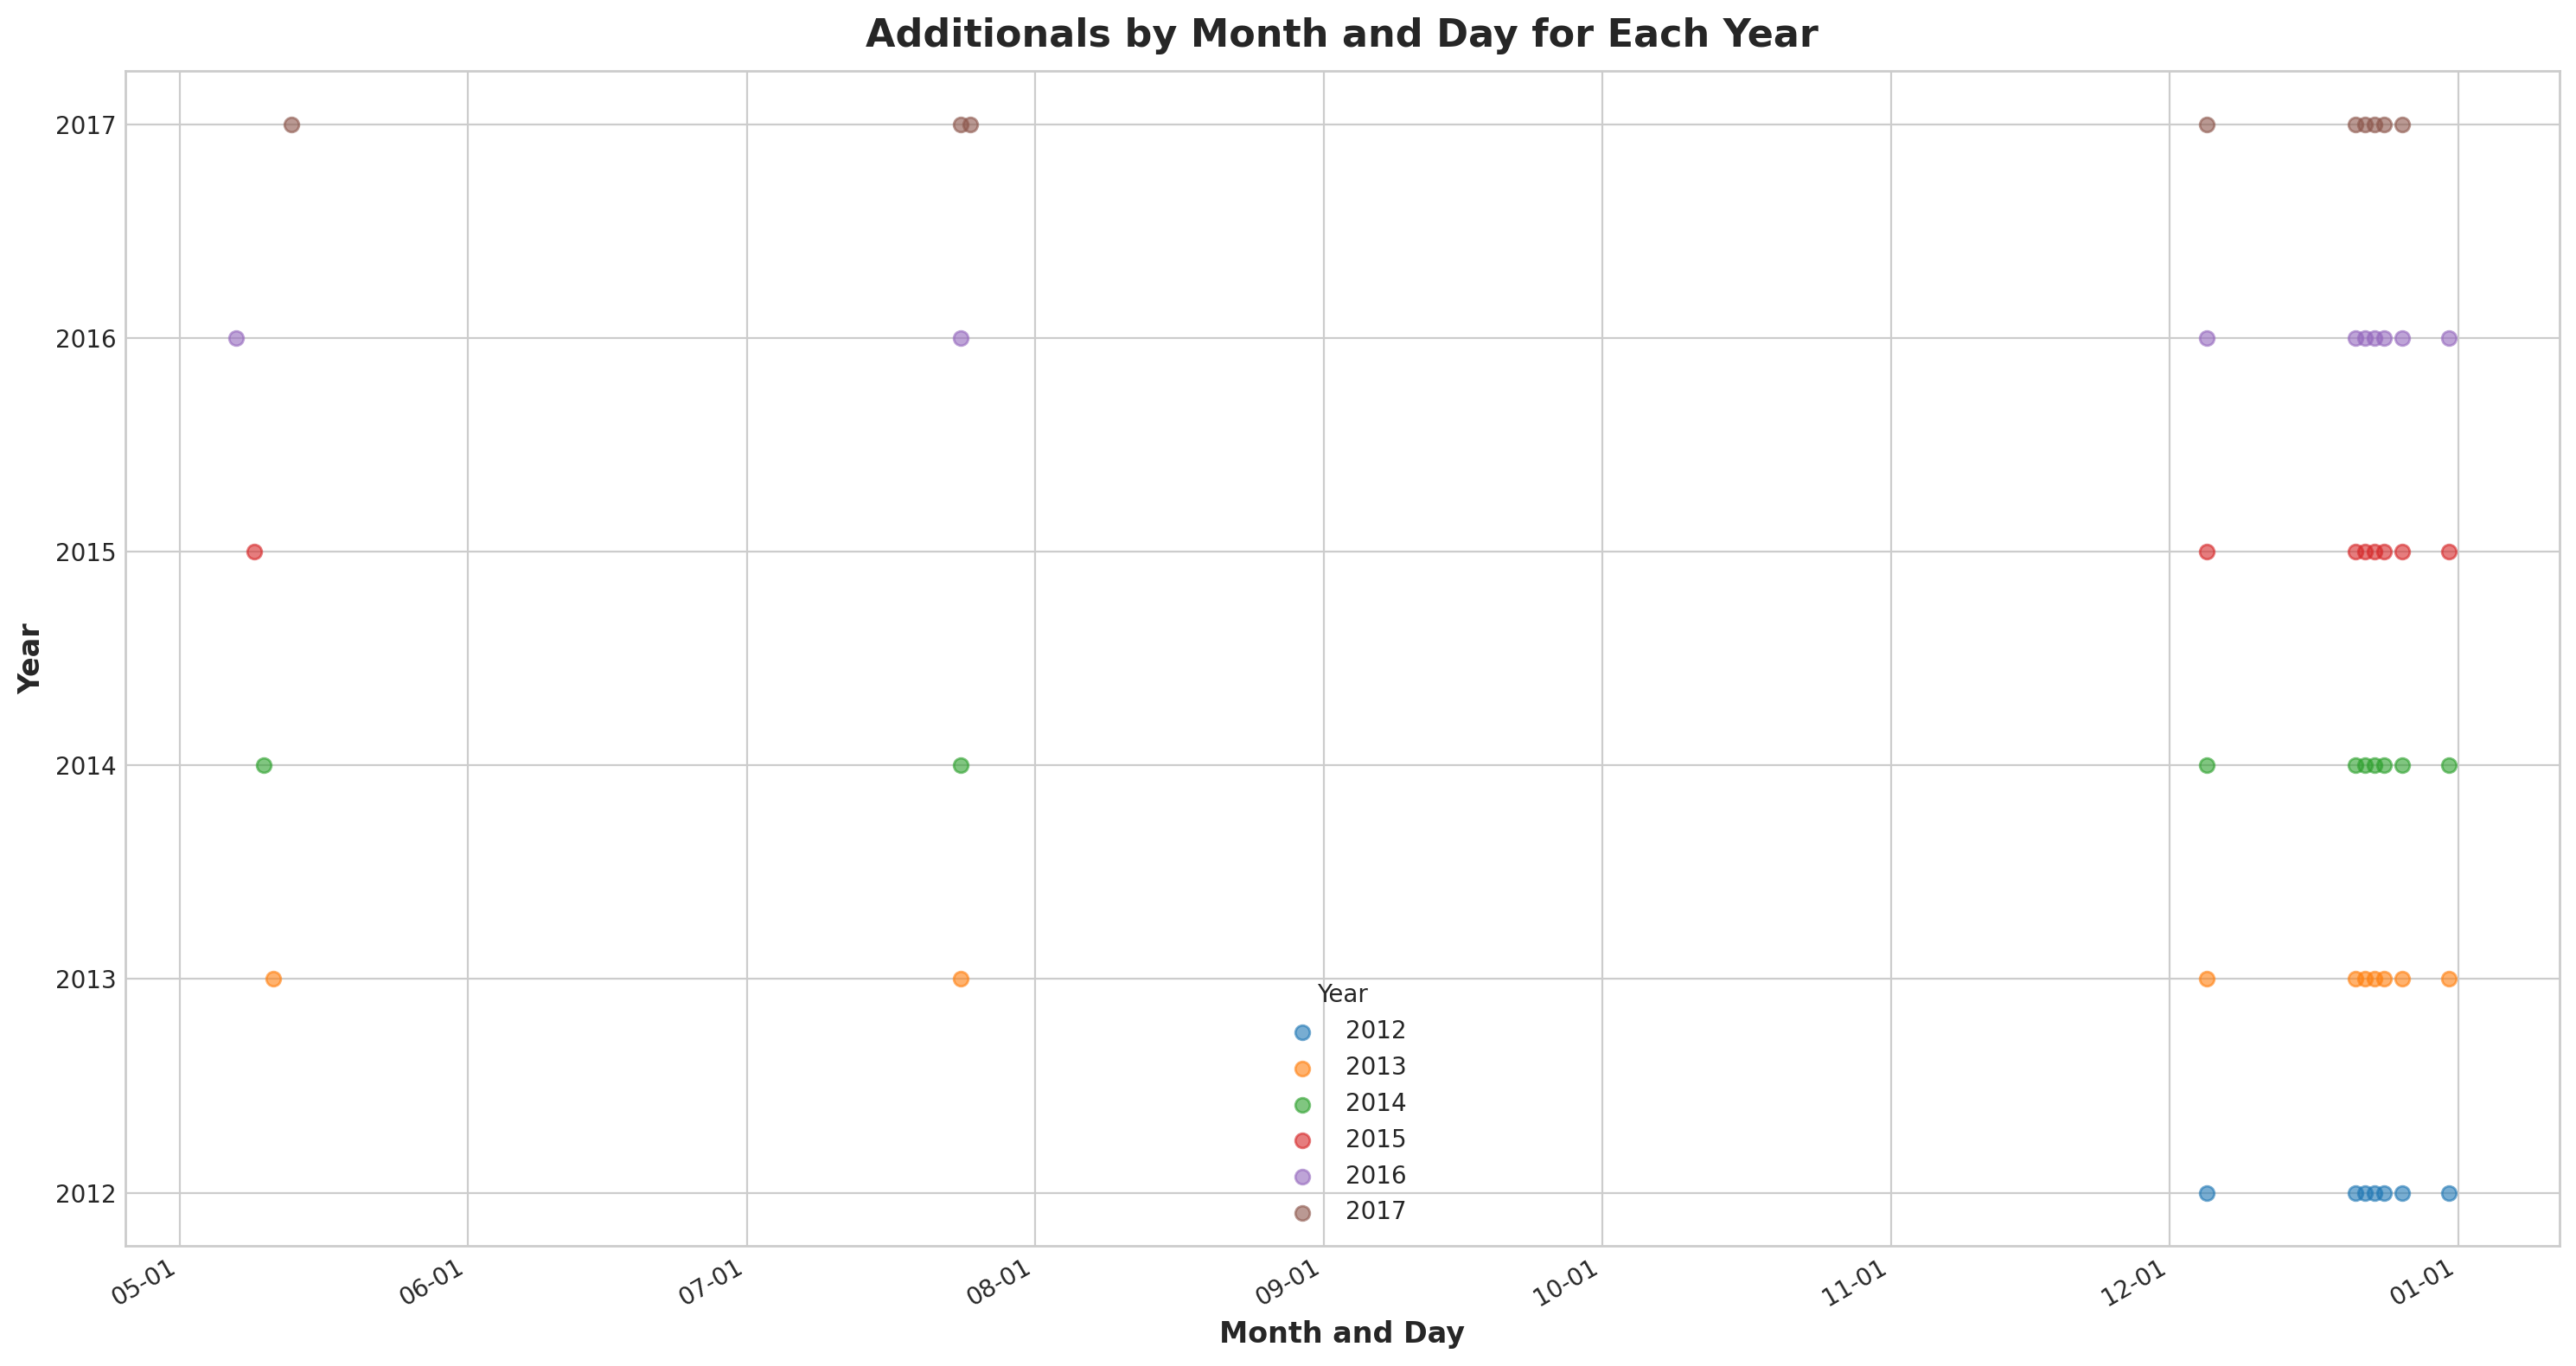

In [43]:
import matplotlib.dates as mdates


# Filter out the data for 'Holiday' and 'Additional' types
holiday_additional_data = holidays_events[
    holidays_events['type'].isin(['Additional'])
].copy()

# Convert 'date' to datetime and create 'month_day' column for plotting
holiday_additional_data['date'] = pd.to_datetime(holiday_additional_data['date'])
holiday_additional_data['month_day'] = holiday_additional_data['date'].dt.strftime('%m-%d')  # MM-DD format

# Create a scatter plot
plt.figure(figsize=(15, 8))

# Plot each year's data with a different marker and/or color
for year in sorted(holiday_additional_data['year'].unique()):
    # Filter data for the year
    yearly_data = holiday_additional_data[holiday_additional_data['year'] == year]
    
    # Convert 'month_day' back to datetime just for plotting purposes
    dates = pd.to_datetime(yearly_data['month_day'], format='%m-%d')
    
    # Plot the data, using day of the year for x and year for y
    plt.scatter(dates, [year] * len(dates), label=year, alpha=0.6)

# Improve formatting and layout
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Rotate date labels
plt.legend(title='Year')
plt.xlabel('Month and Day')
plt.ylabel('Year')
plt.title('Additionals by Month and Day for Each Year')
plt.grid(True)
plt.show()

Same for additionals as well. Should inspect the affect on sales.

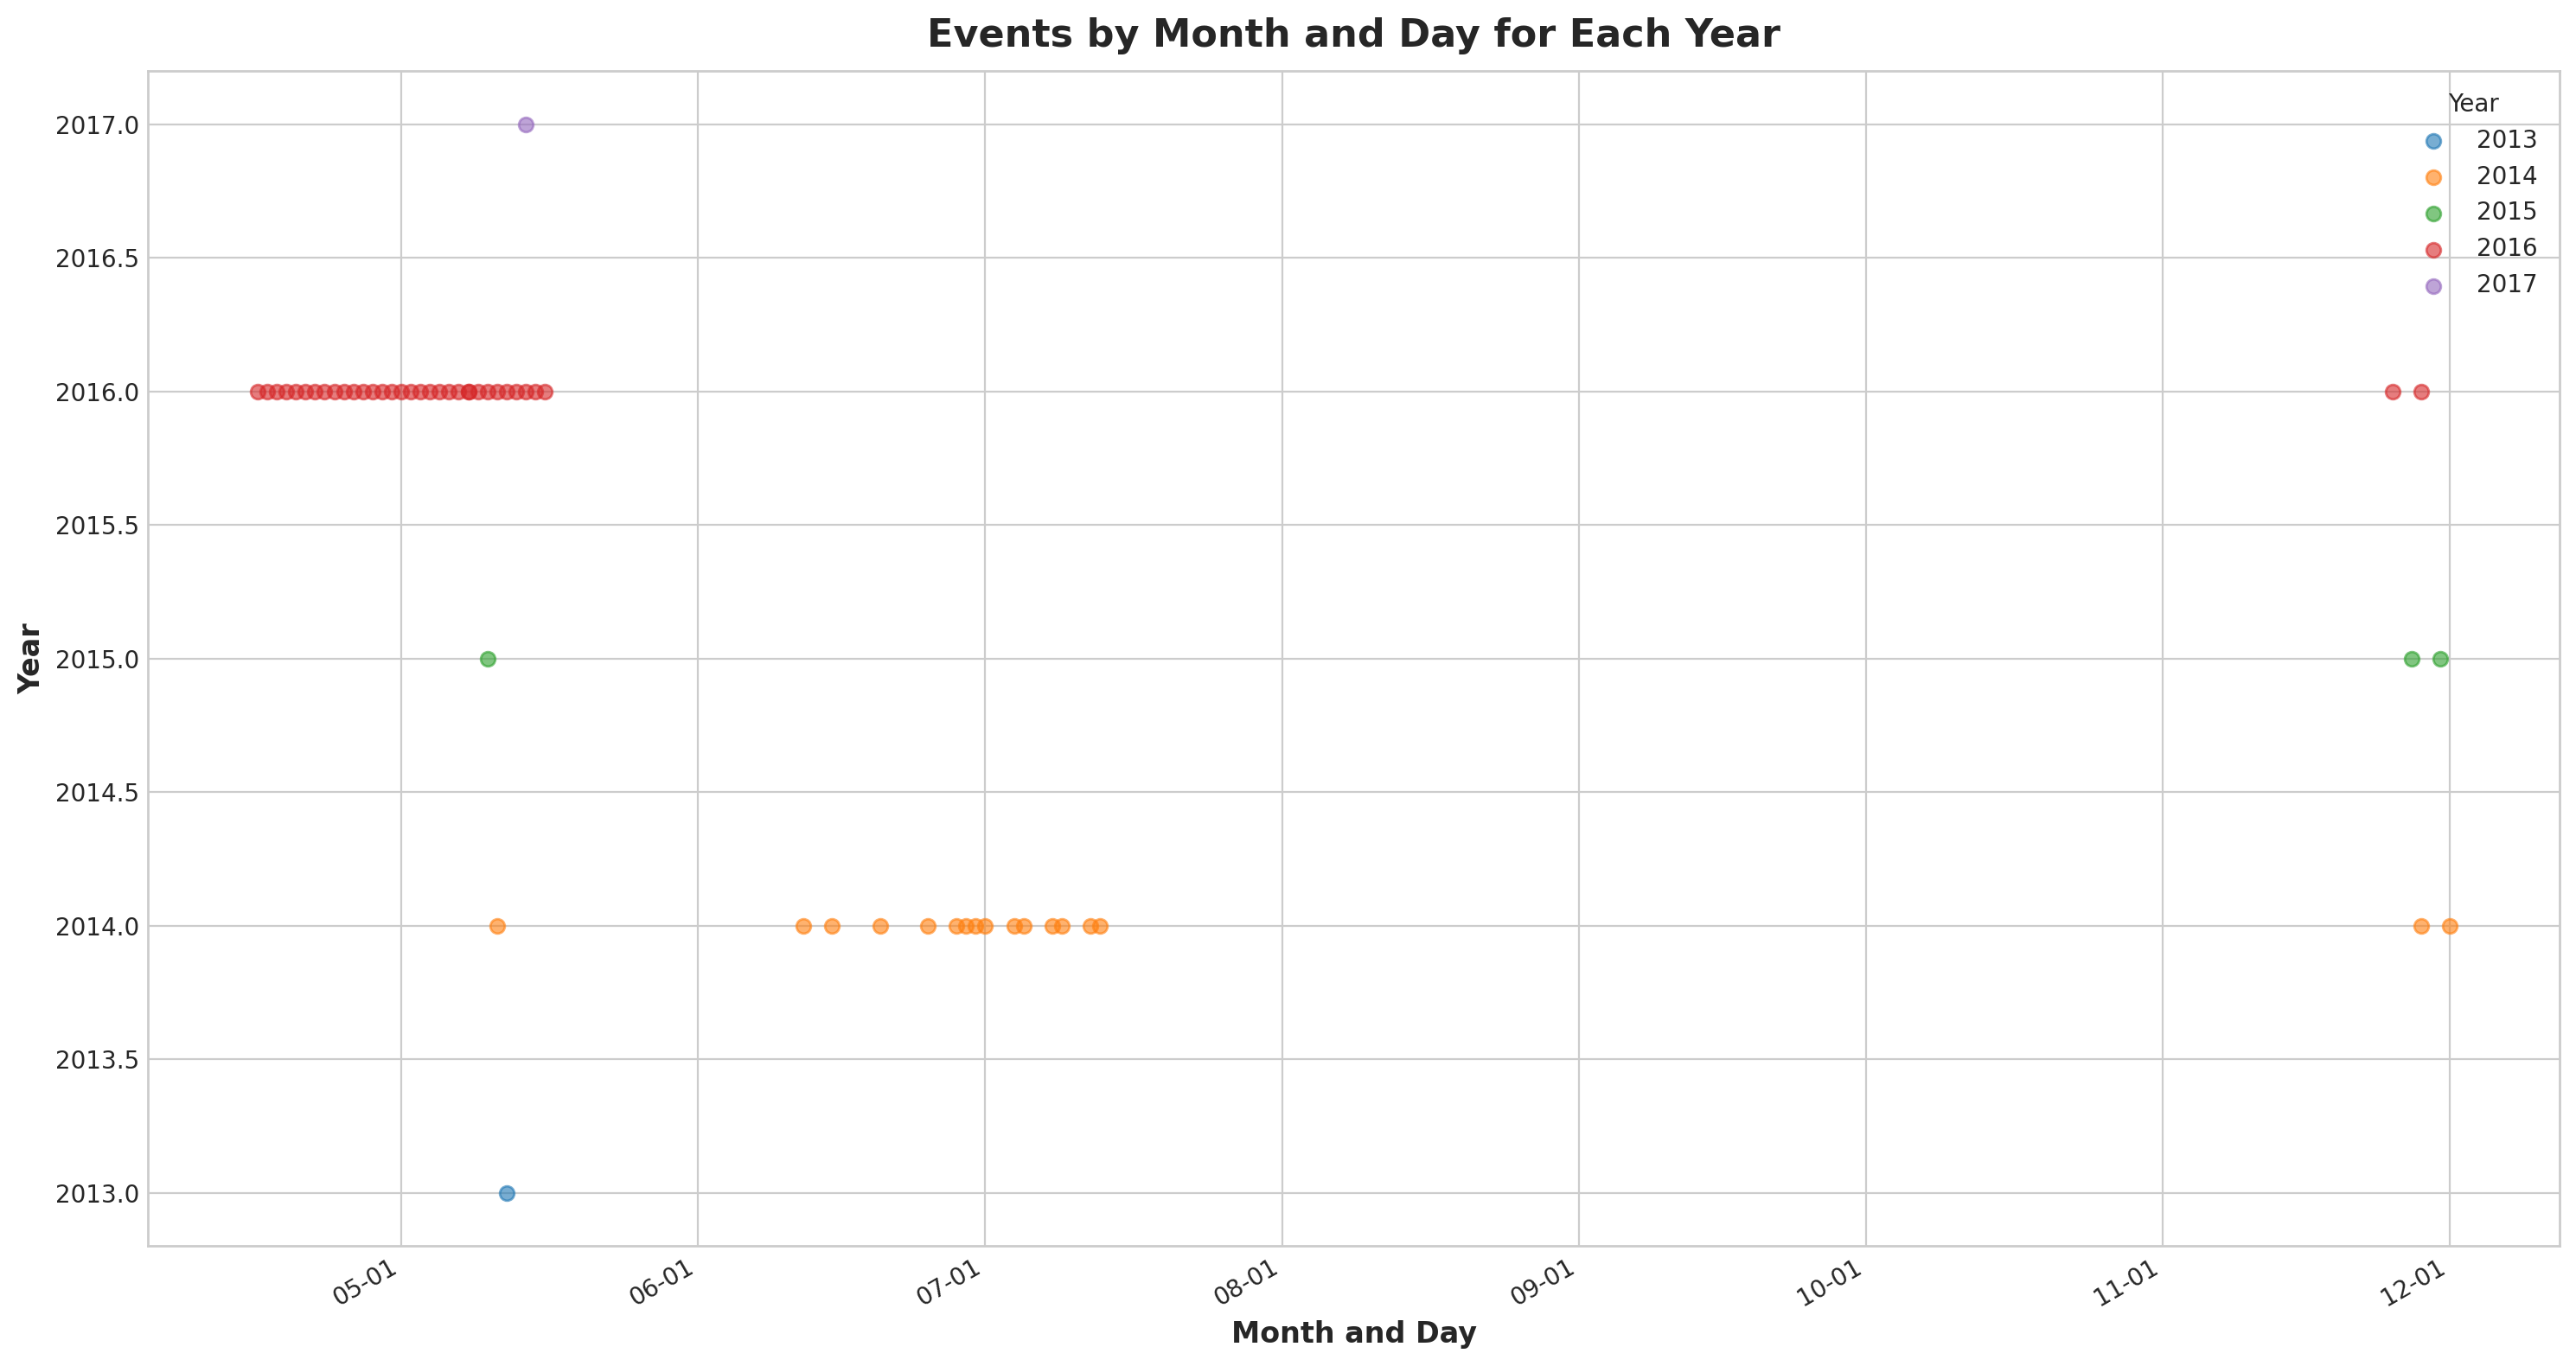

In [44]:
import matplotlib.dates as mdates


# Filter out the data for 'Holiday' and 'Additional' types
holiday_additional_data = holidays_events[
    holidays_events['type'].isin(['Event'])
].copy()

# Convert 'date' to datetime and create 'month_day' column for plotting
holiday_additional_data['date'] = pd.to_datetime(holiday_additional_data['date'])
holiday_additional_data['month_day'] = holiday_additional_data['date'].dt.strftime('%m-%d')  # MM-DD format

# Create a scatter plot
plt.figure(figsize=(15, 8))

# Plot each year's data with a different marker and/or color
for year in sorted(holiday_additional_data['year'].unique()):
    # Filter data for the year
    yearly_data = holiday_additional_data[holiday_additional_data['year'] == year]
    
    # Convert 'month_day' back to datetime just for plotting purposes
    dates = pd.to_datetime(yearly_data['month_day'], format='%m-%d')
    
    # Plot the data, using day of the year for x and year for y
    plt.scatter(dates, [year] * len(dates), label=year, alpha=0.6)

# Improve formatting and layout
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Rotate date labels
plt.legend(title='Year')
plt.xlabel('Month and Day')
plt.ylabel('Year')
plt.title('Events by Month and Day for Each Year')
plt.grid(True)
plt.show()

In [45]:
df = average_sales.to_frame()
lag_1 = df['sales'].shift(1)
df['lag_1'] = lag_1  # add to dataframe

X = df.loc[:, ['lag_1']].dropna()  # features
y = df.loc[:, 'sales']  # target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)


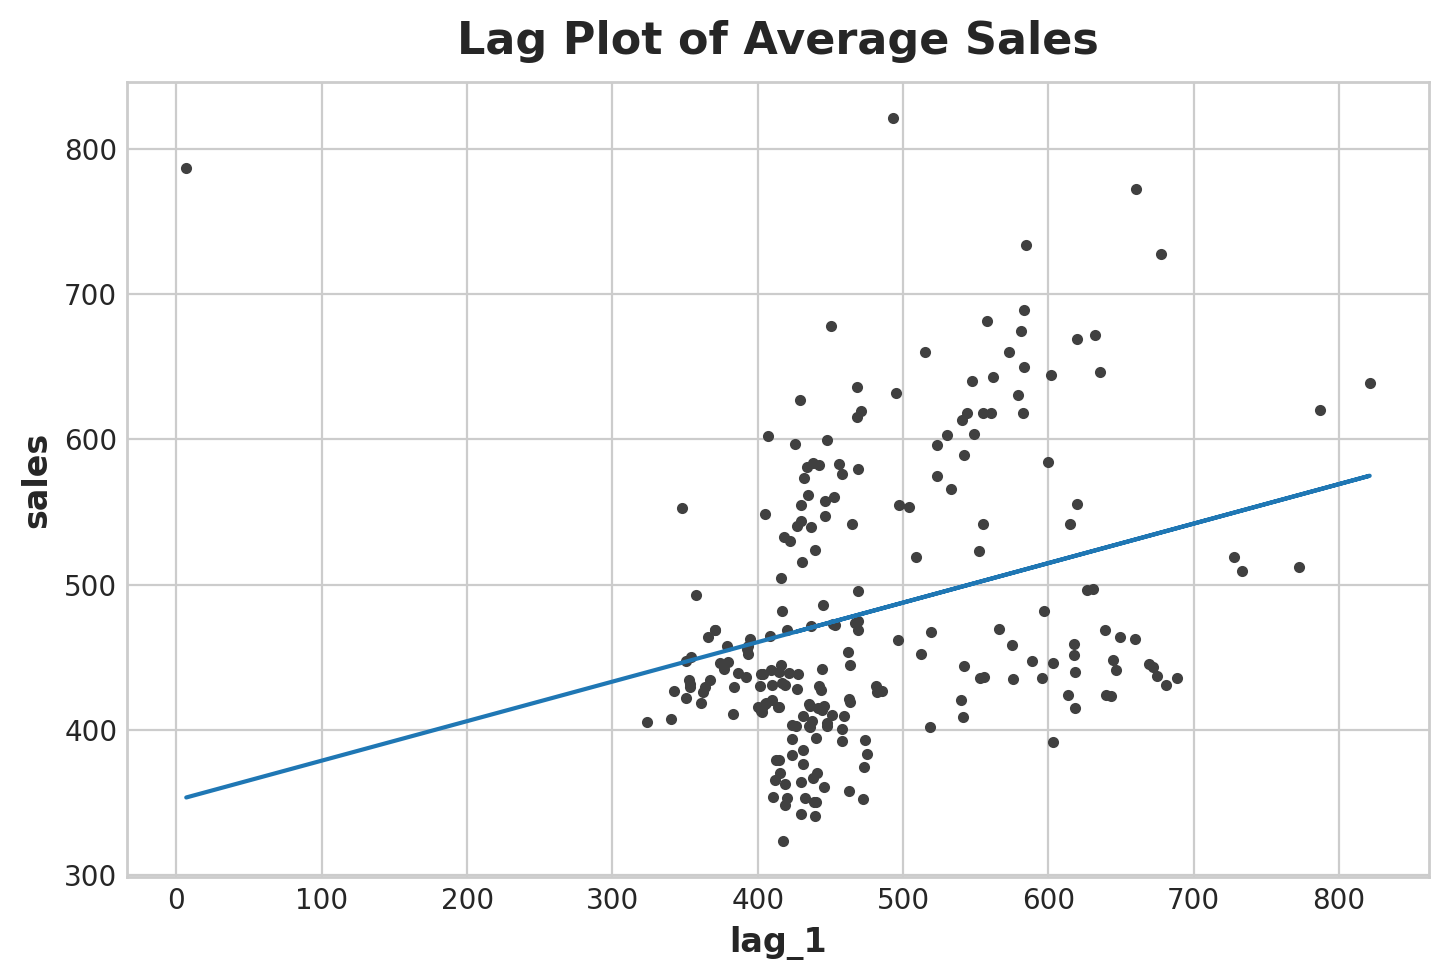

In [46]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

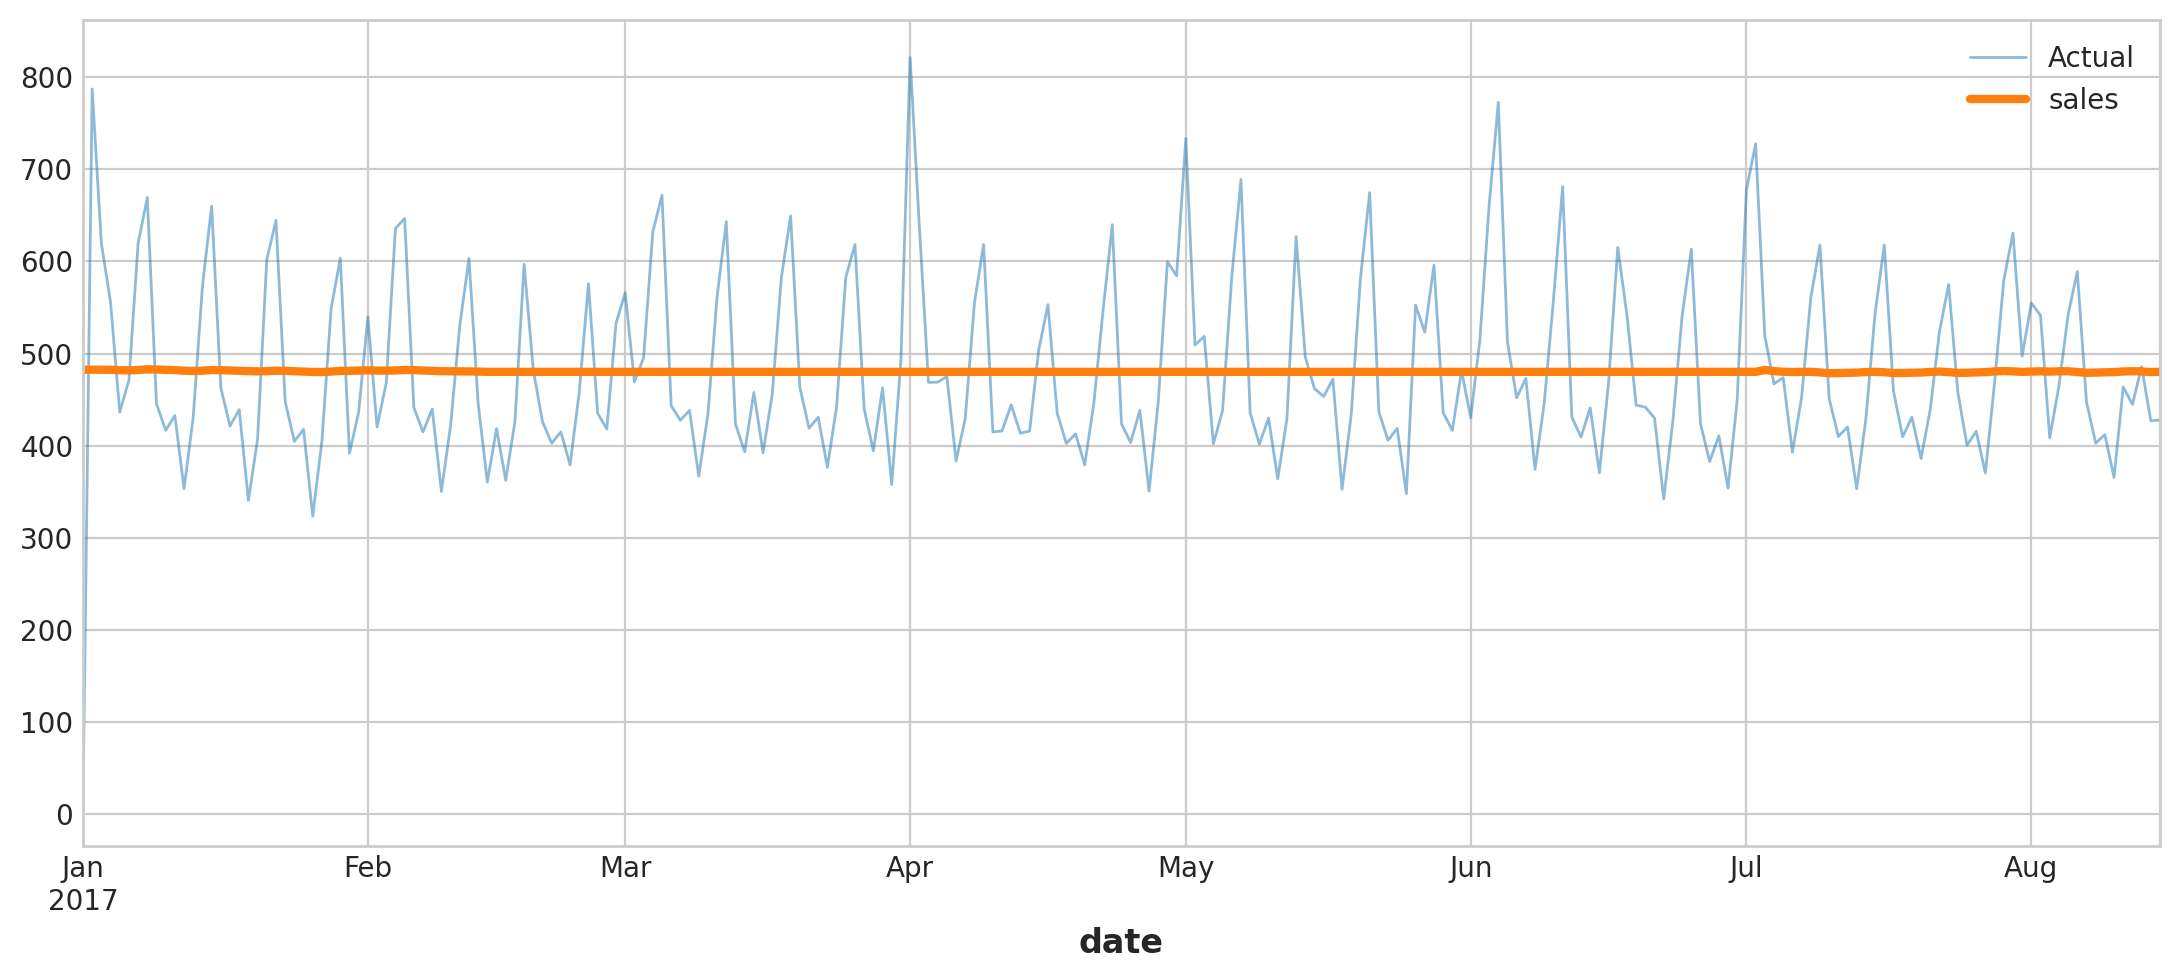

In [47]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()


ax = average_sales.plot(alpha=0.5, label='Actual', linewidth=1)
ax = trend.plot(ax=ax, linewidth=3)

# Show the legend
ax.legend()

# Show the plot
plt.show()

In [48]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy()  # the target

dp = DeterministicProcess(
    index=y.index,
    order=3,
    drop=True,)

X = dp.in_sample()

X_fore = dp.out_of_sample(steps=90)

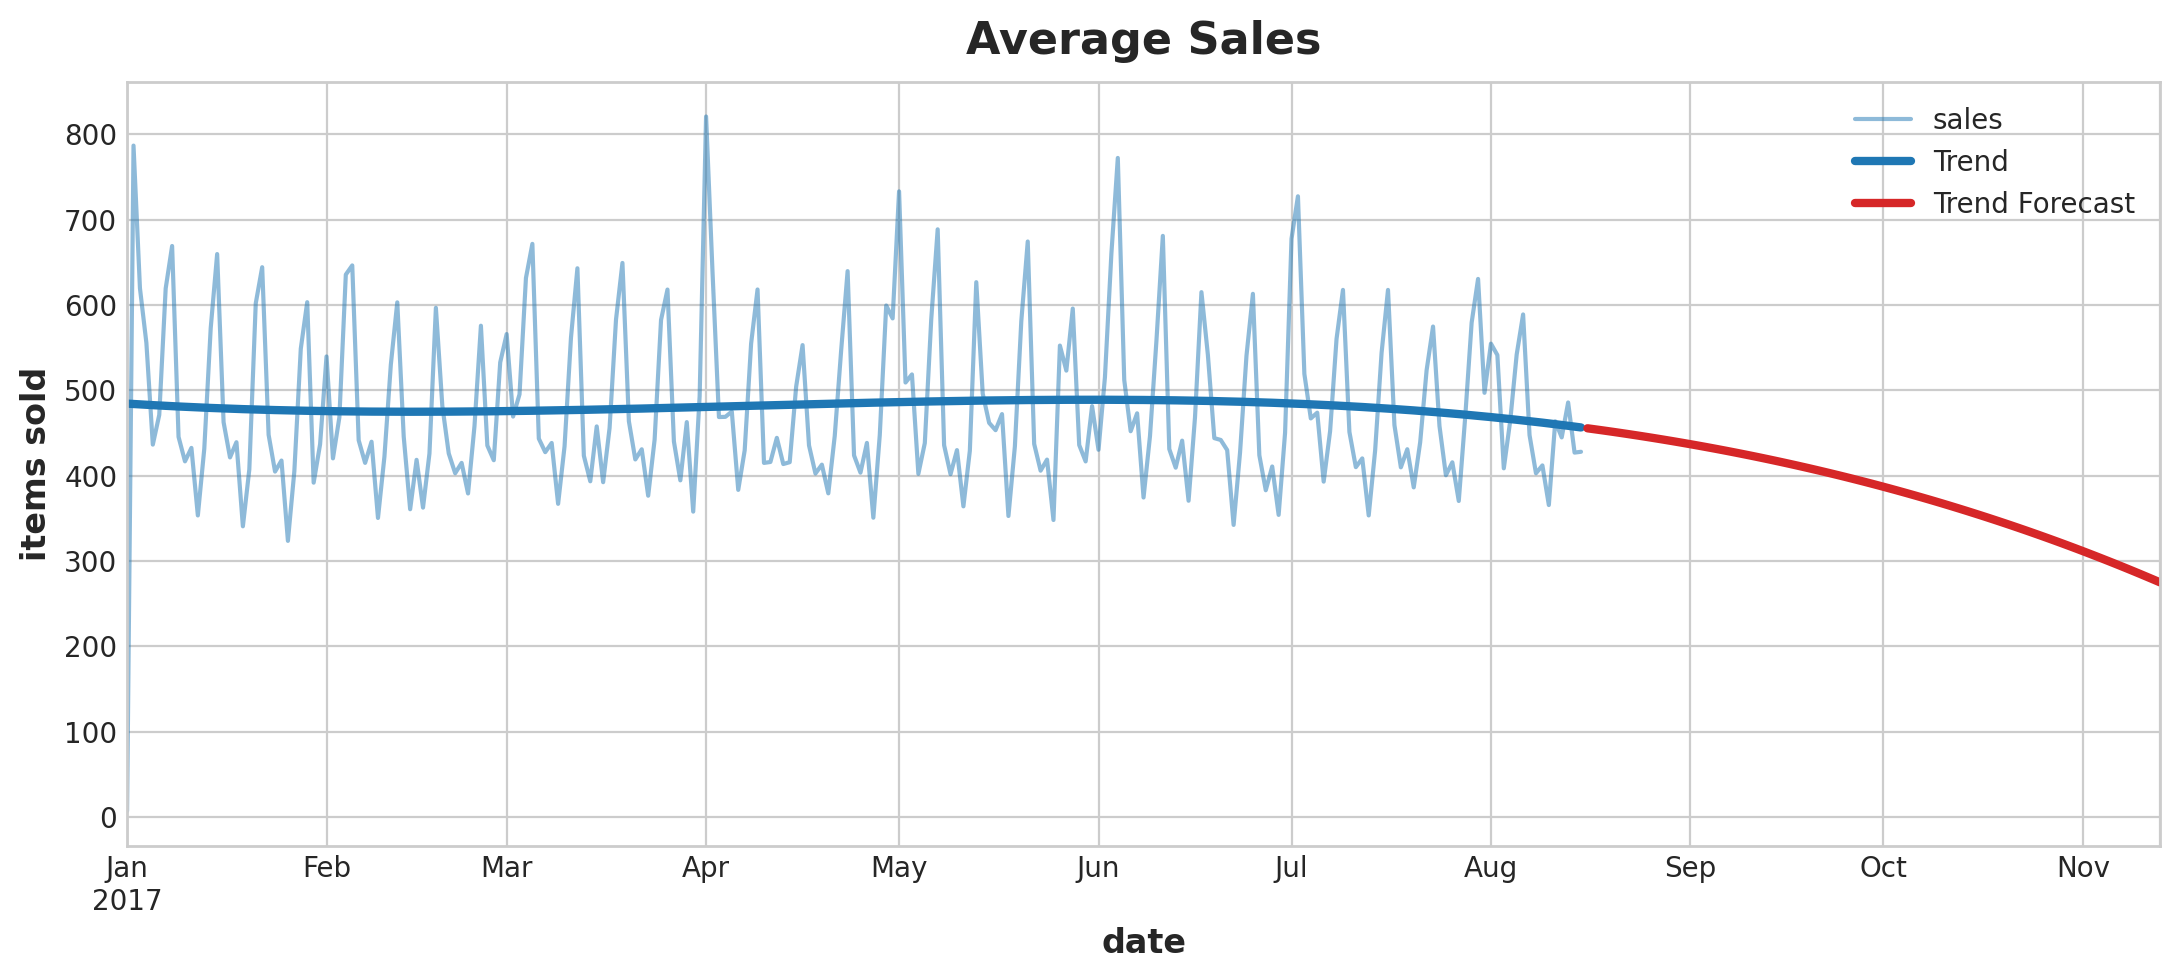

In [49]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

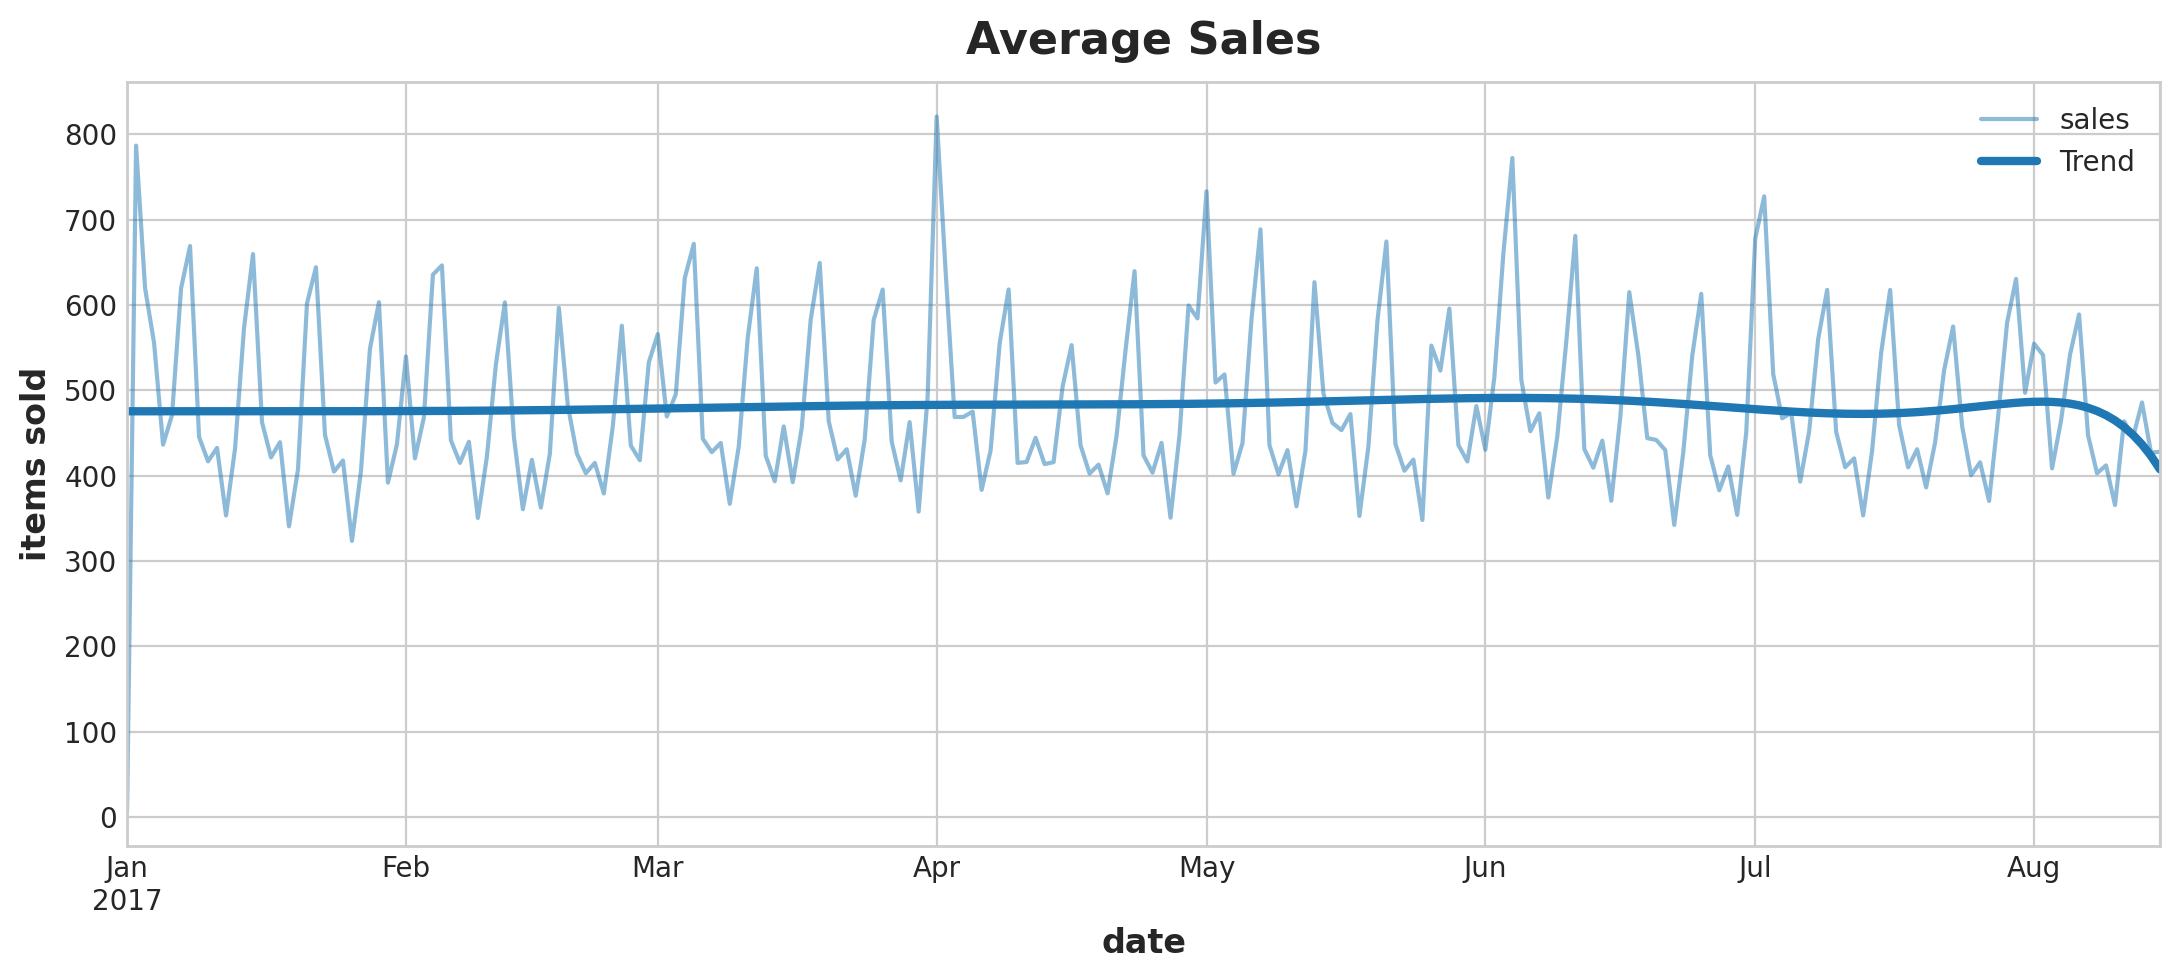

In [50]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(index=y.index, order=11)
X = dp.in_sample()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax.legend();

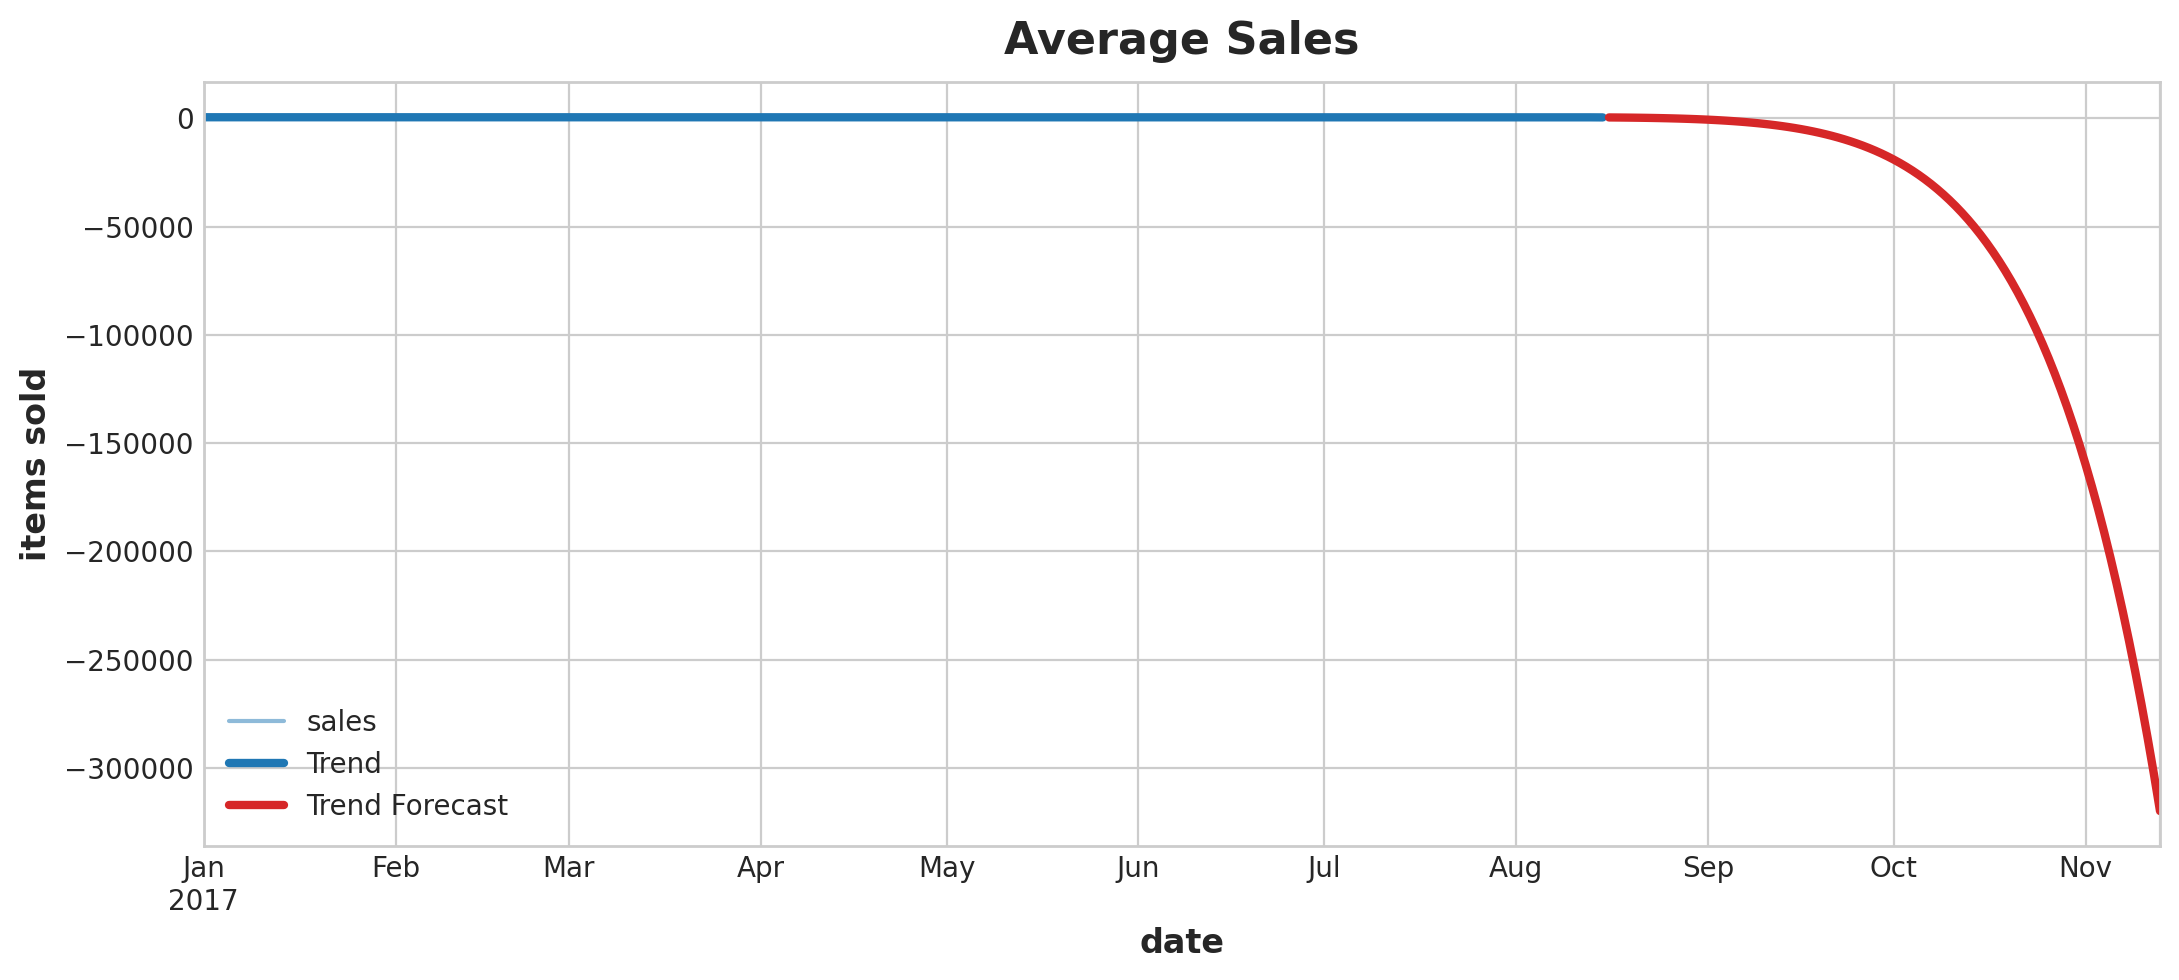

In [51]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();